In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sqlite3

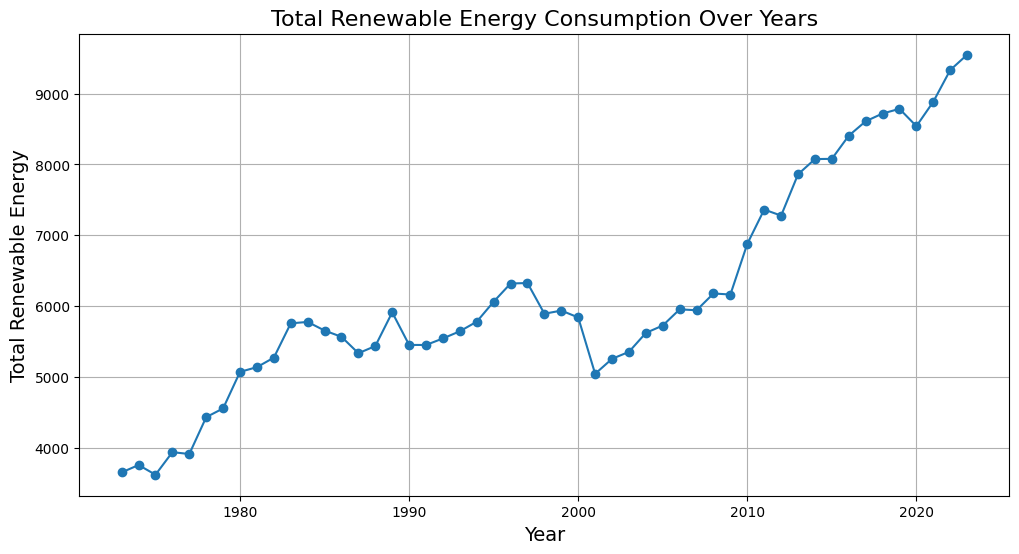

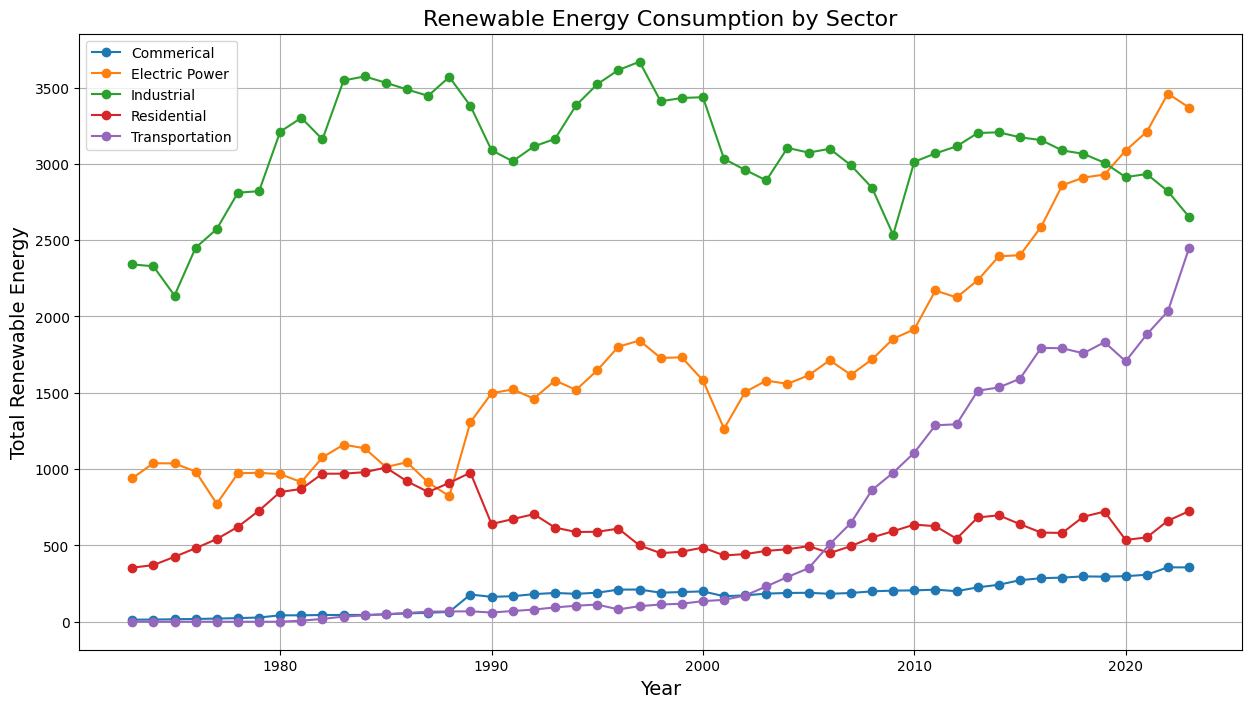

Wood Energy                         112154.045
Biomass Adjusted                    108938.275
Conventional Hydroelectric Power     48224.273
Waste Energy                         17804.403
Wind Energy                          13006.233
Solar Energy                          6123.142
Geothermal Energy                     3503.576
dtype: float64


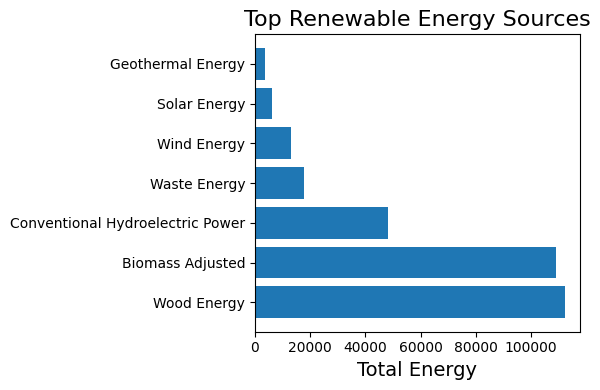

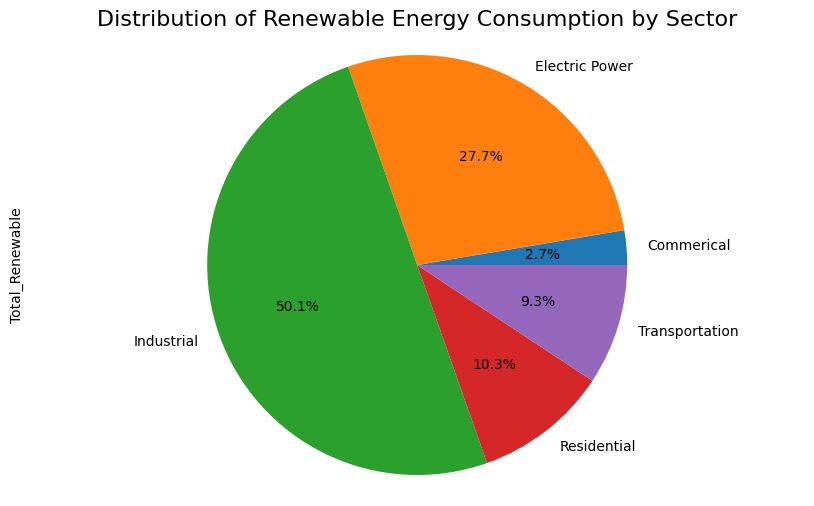

<Figure size 1200x600 with 0 Axes>

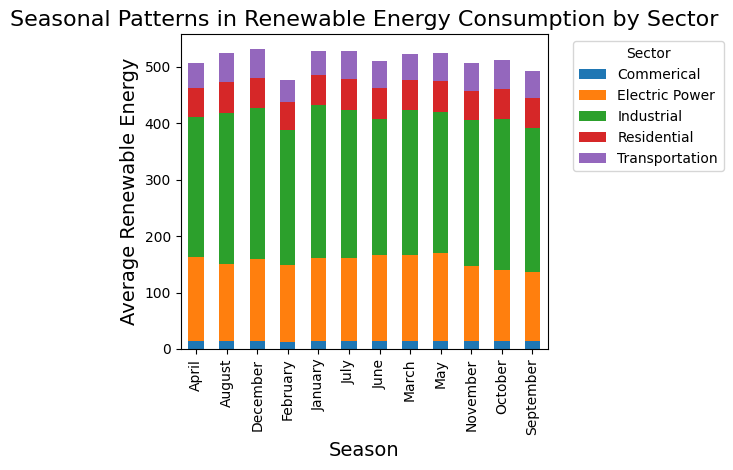

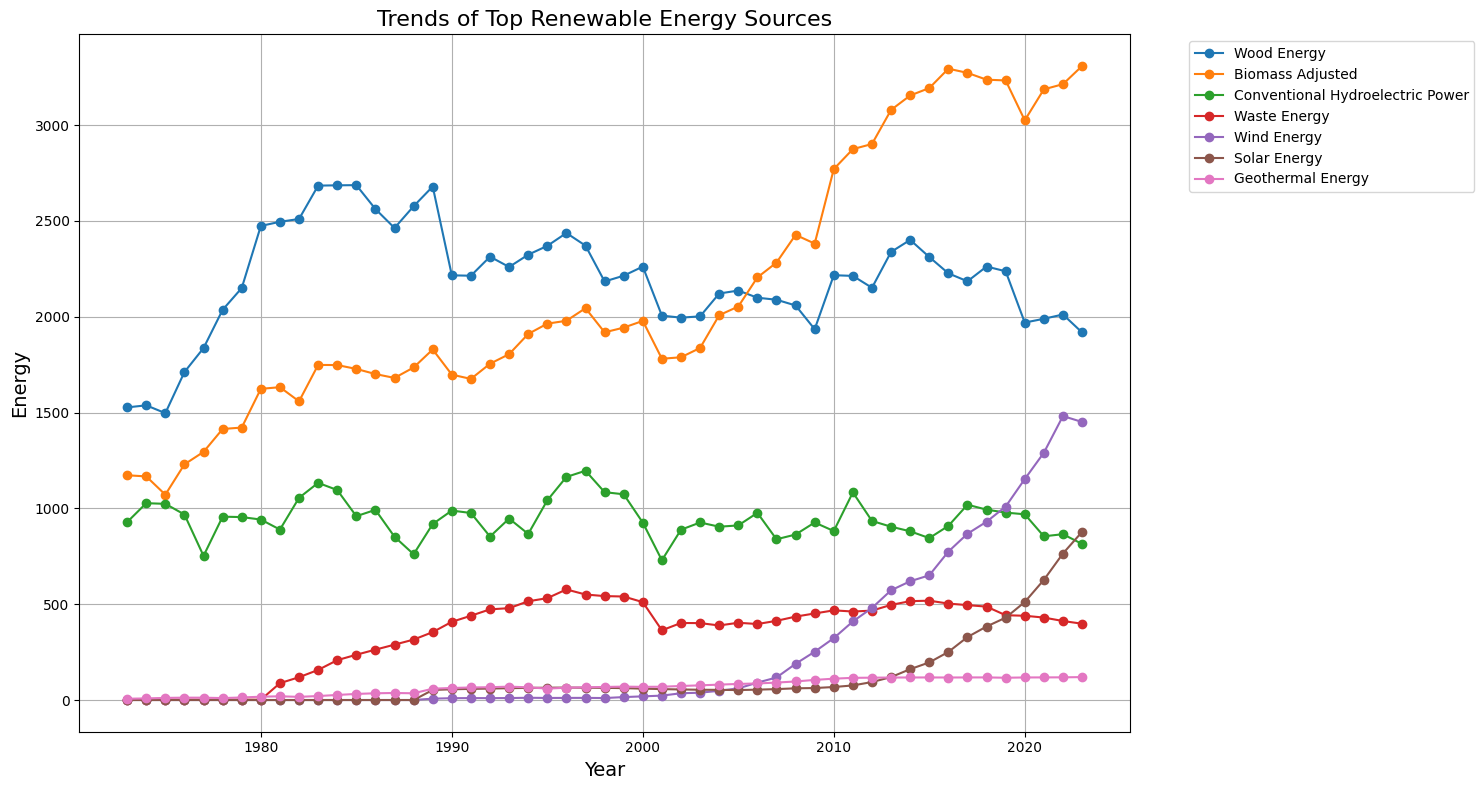


Summary Statistics by Sector:
                count        mean        std      min        25%       50%  \
Sector                                                                       
Commerical      612.0   13.641489   8.163499    1.030    4.10800   15.5040   
Electric Power  612.0  142.281340  60.862320   53.560   93.40350  130.8415   
Industrial      612.0  257.297141  35.798190  158.158  238.70100  257.8025   
Residential     612.0   52.979511  14.576491   27.164   41.10075   50.9180   
Transportation  612.0   47.779260  61.368188    0.000    4.22400    9.6300   

                      75%      max  
Sector                              
Commerical       17.56475   31.960  
Electric Power  169.15075  323.335  
Industrial      280.52200  385.483  
Residential      59.90825   85.781  
Transportation   97.77000  225.176  

Summary Statistics by Energy Source:
       Solar Energy  Wind Energy  Hydroelectric Power  Geothermal Energy  \
count   3060.000000  3060.000000          3060.00

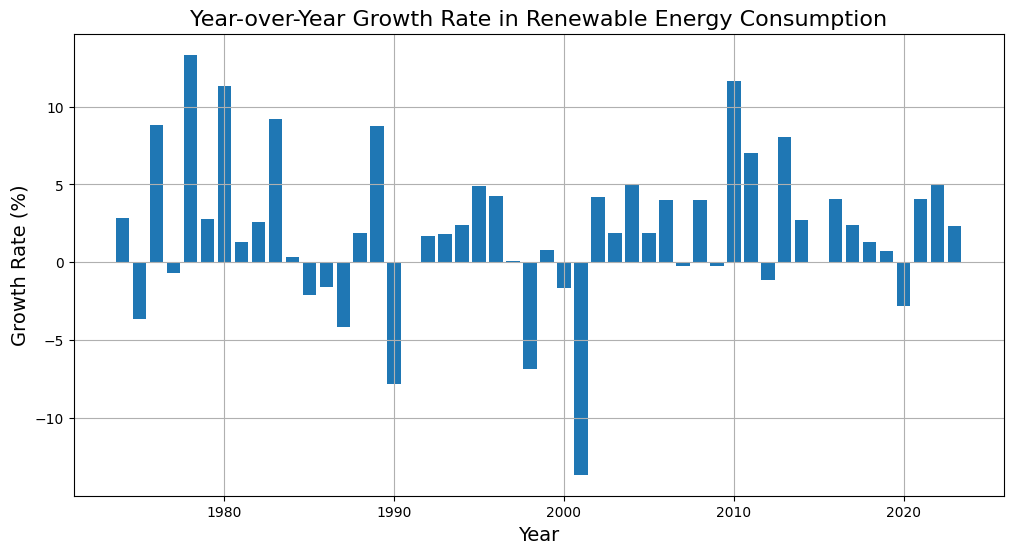

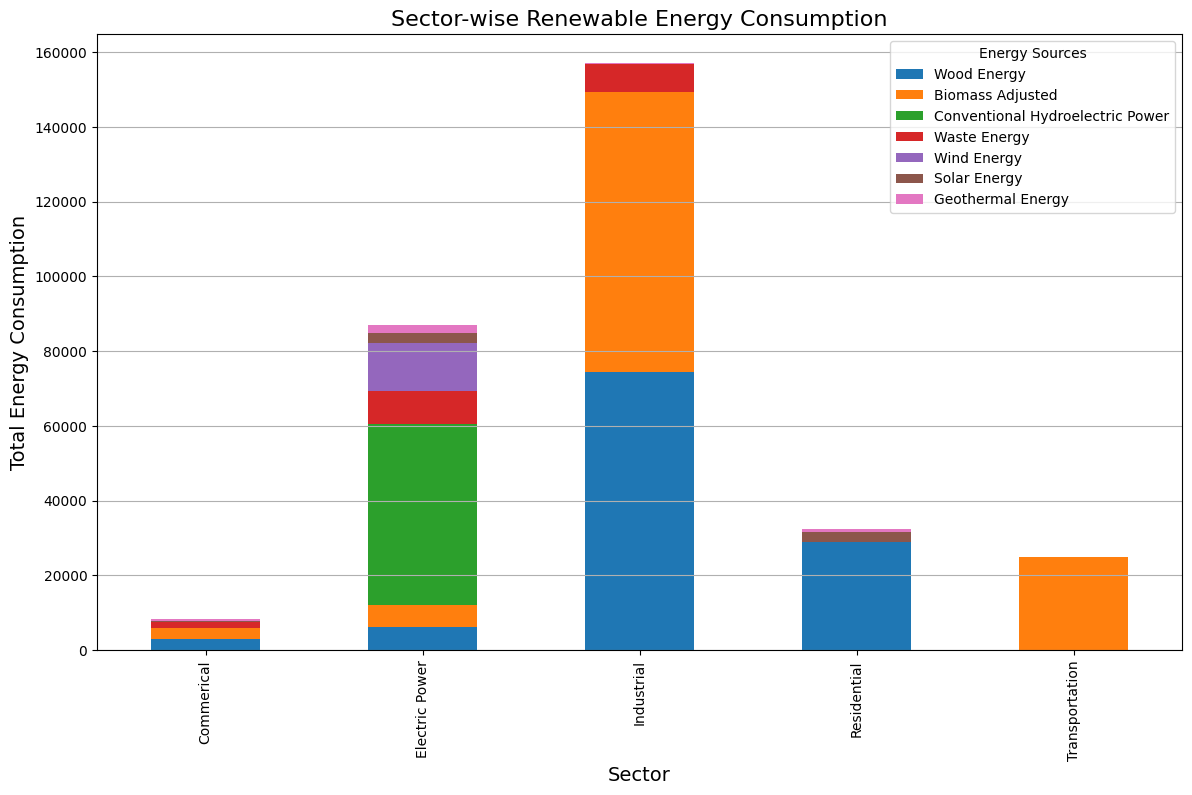

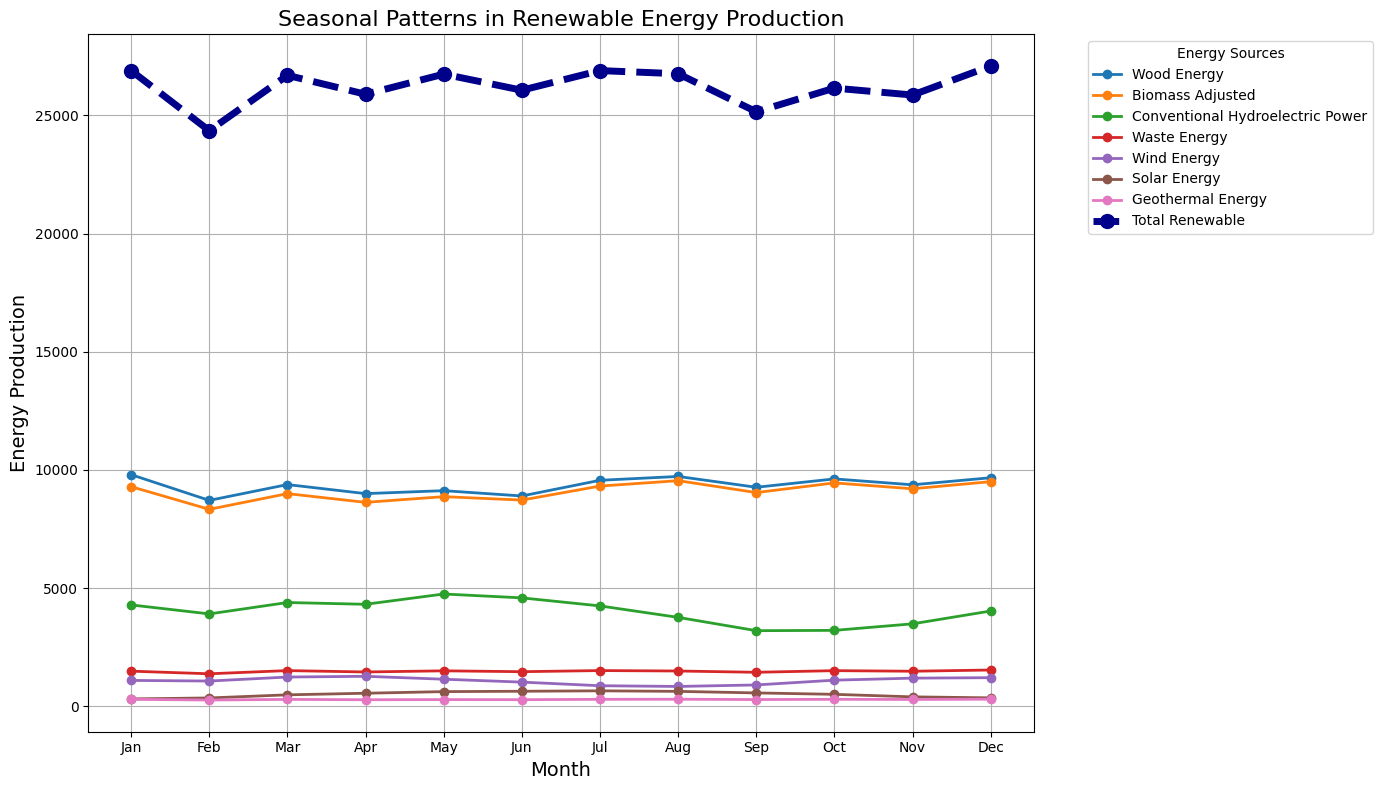

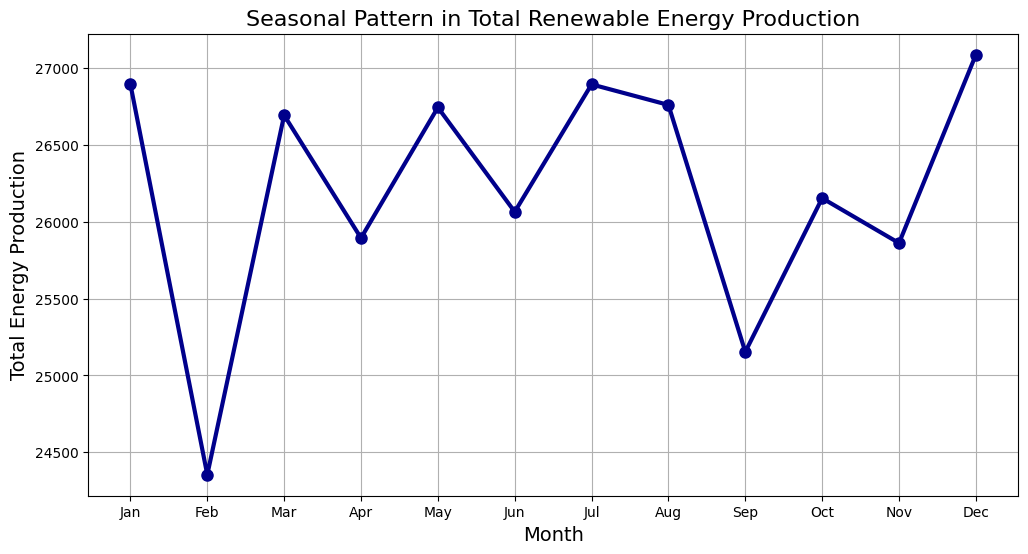

In [31]:
conn = sqlite3.connect('data/data.db')

renewable_df = pd.read_sql_query("SELECT * FROM renewable_energy", conn)

conn.close()


renewable_df = renewable_df[renewable_df['Year'] < 2024].copy()
renewable_df['Biomass Adjusted'] = renewable_df['Biomass Energy'] - (renewable_df['Biomass Losses and Co-products'] + renewable_df['Waste Energy'])
# drop the Total_Renewable column and recalculate it
renewable_sources = ['Solar Energy', 'Wind Energy', 'Hydroelectric Power', 'Geothermal Energy', 
                    'Wood Energy', 'Waste Energy', 'Biomass Adjusted', 'Renewable Diesel Fuel', 
                    'Other Biofuels', 'Conventional Hydroelectric Power', 'Biodiesel']

# drop existing Total_Renewable column and calculate new total
renewable_df = renewable_df.drop('Total Renewable Energy', axis=1)
renewable_df['Total_Renewable'] = renewable_df[renewable_sources].sum(axis=1)

# 1. overall yearly trend
yearly_total = renewable_df.groupby('Year')['Total_Renewable'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(yearly_total['Year'], yearly_total['Total_Renewable'], marker='o')
plt.title('Total Renewable Energy Consumption Over Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Renewable Energy', fontsize=14)
plt.grid(True)
plt.show()

# 2. sector-wise yearly trends
plt.figure(figsize=(15, 8))
for sector in renewable_df['Sector'].unique():
    sector_data = renewable_df[renewable_df['Sector'] == sector].groupby('Year')['Total_Renewable'].sum()
    plt.plot(sector_data.index, sector_data.values, label=sector, marker='o')
plt.title('Renewable Energy Consumption by Sector', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Renewable Energy', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# 3. important energy sources analysis
# total contribution of each source
source_totals = renewable_df[renewable_sources].sum()
top_sources = source_totals.sort_values(ascending=False).head(7)
print(top_sources)
plt.figure(figsize=(6, 4))
plt.barh(range(len(top_sources)), top_sources.values)
plt.yticks(range(len(top_sources)), top_sources.index)
plt.title('Top Renewable Energy Sources', fontsize=16)
plt.xlabel('Total Energy', fontsize=14)
plt.tight_layout()
plt.show()

# 4. sector-wise distribution
sector_totals = renewable_df.groupby('Sector')['Total_Renewable'].sum()

plt.figure(figsize=(10, 6))
sector_totals.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Renewable Energy Consumption by Sector', fontsize=16)
plt.axis('equal')
plt.show()

# 5. seasonal patterns
renewable_df['Season'] = pd.to_datetime(renewable_df['Month'], format='%m').dt.strftime('%B')
seasonal_avg = renewable_df.groupby(['Season', 'Sector'])['Total_Renewable'].mean().unstack()

plt.figure(figsize=(12, 6))
seasonal_avg.plot(kind='bar', stacked=True)
plt.title('Seasonal Patterns in Renewable Energy Consumption by Sector', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Average Renewable Energy', fontsize=14)
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# 6. source-wise trends for top sources
plt.figure(figsize=(15, 8))
for source in top_sources.index:
    source_data = renewable_df.groupby('Year')[source].sum()
    plt.plot(source_data.index, source_data.values, label=source, marker='o')
plt.title('Trends of Top Renewable Energy Sources', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Energy', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. summary statistics
print("\nsummary statistics by sector:")
print(renewable_df.groupby('Sector')['Total_Renewable'].describe())

print("\nSummary Statistics by Energy Source:")
print(renewable_df[renewable_sources].describe())

# 8. growth rate analysis
yearly_growth = yearly_total.set_index('Year')['Total_Renewable'].pct_change() * 100

plt.figure(figsize=(12, 6))
plt.bar(yearly_growth.index, yearly_growth.values)
plt.title('Year-over-Year Growth Rate in Renewable Energy Consumption', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Growth Rate (%)', fontsize=14)
plt.grid(True)
plt.show()


# 9. sector-wise energy source distribution
sector_trends = renewable_df.groupby('Sector')[top_sources.index].sum()

# plotting sector-wise reliance on renewable energy sources
sector_trends.plot(kind='bar', stacked=True, figsize=(14, 8))

plt.title("Sector-wise Renewable Energy Consumption", fontsize=16)
plt.xlabel("Sector", fontsize=14) 
plt.ylabel("Total Energy Consumption", fontsize=14)
plt.legend(title="Energy Sources", bbox_to_anchor=(1, 1))
plt.grid(axis='y')
plt.show()

# 10. seasonal analysis
# grouping data by Month and summing across all years to detect seasonal patterns
monthly_trends = renewable_df.groupby('Month')[renewable_sources].sum()

# plotting seasonal patterns in renewable energy production
plt.figure(figsize=(14, 8))

# plot individual sources
for source in top_sources.index:
    plt.plot(monthly_trends.index, monthly_trends[source], marker='o', linestyle='-', label=source, linewidth=2)

# add total renewable line
monthly_total = renewable_df.groupby('Month')['Total_Renewable'].sum()
plt.plot(monthly_total.index, monthly_total.values, marker='o', linewidth=5, color='darkblue', label='Total Renewable', linestyle='--', markersize=10)

plt.title("Seasonal Patterns in Renewable Energy Production", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Energy Production", fontsize=14)
plt.xticks(ticks=range(1, 13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.legend(title="Energy Sources", bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(monthly_total.index, monthly_total.values, marker='o', linewidth=3, color='darkblue', markersize=8)
plt.title("Seasonal Pattern in Total Renewable Energy Production", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Total Energy Production", fontsize=14)
plt.xticks(ticks=range(1, 13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.grid(True)
plt.show()



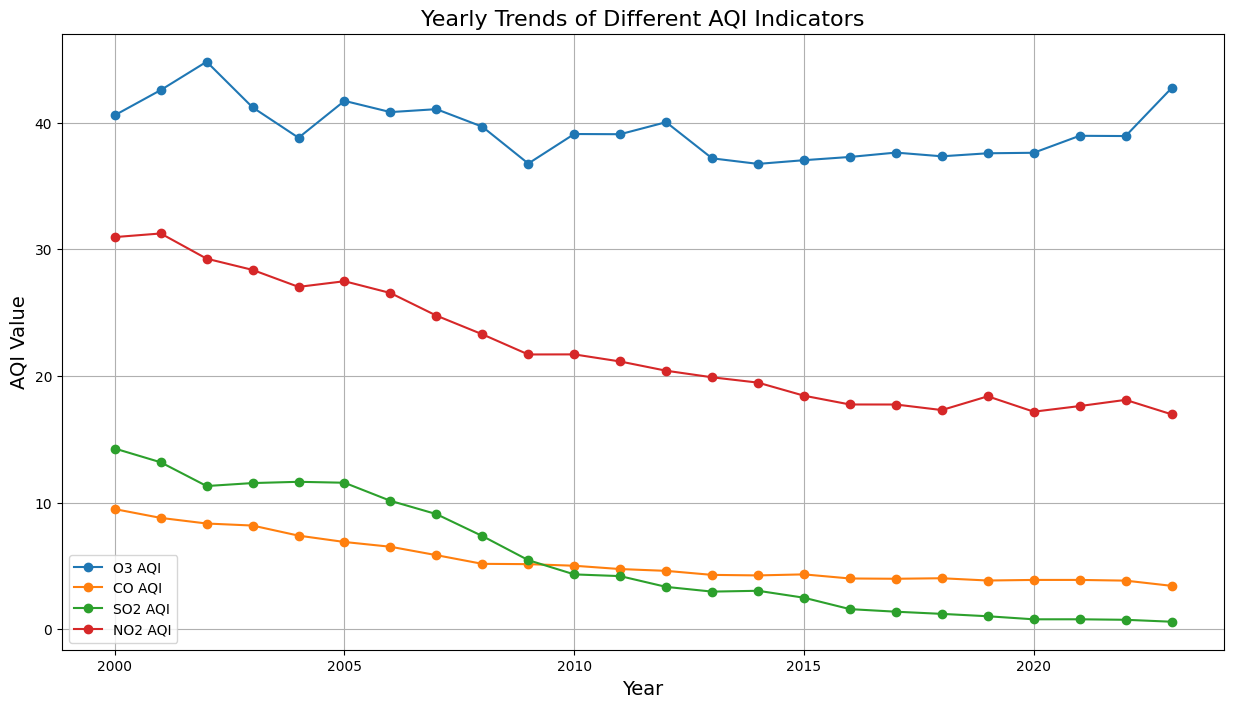

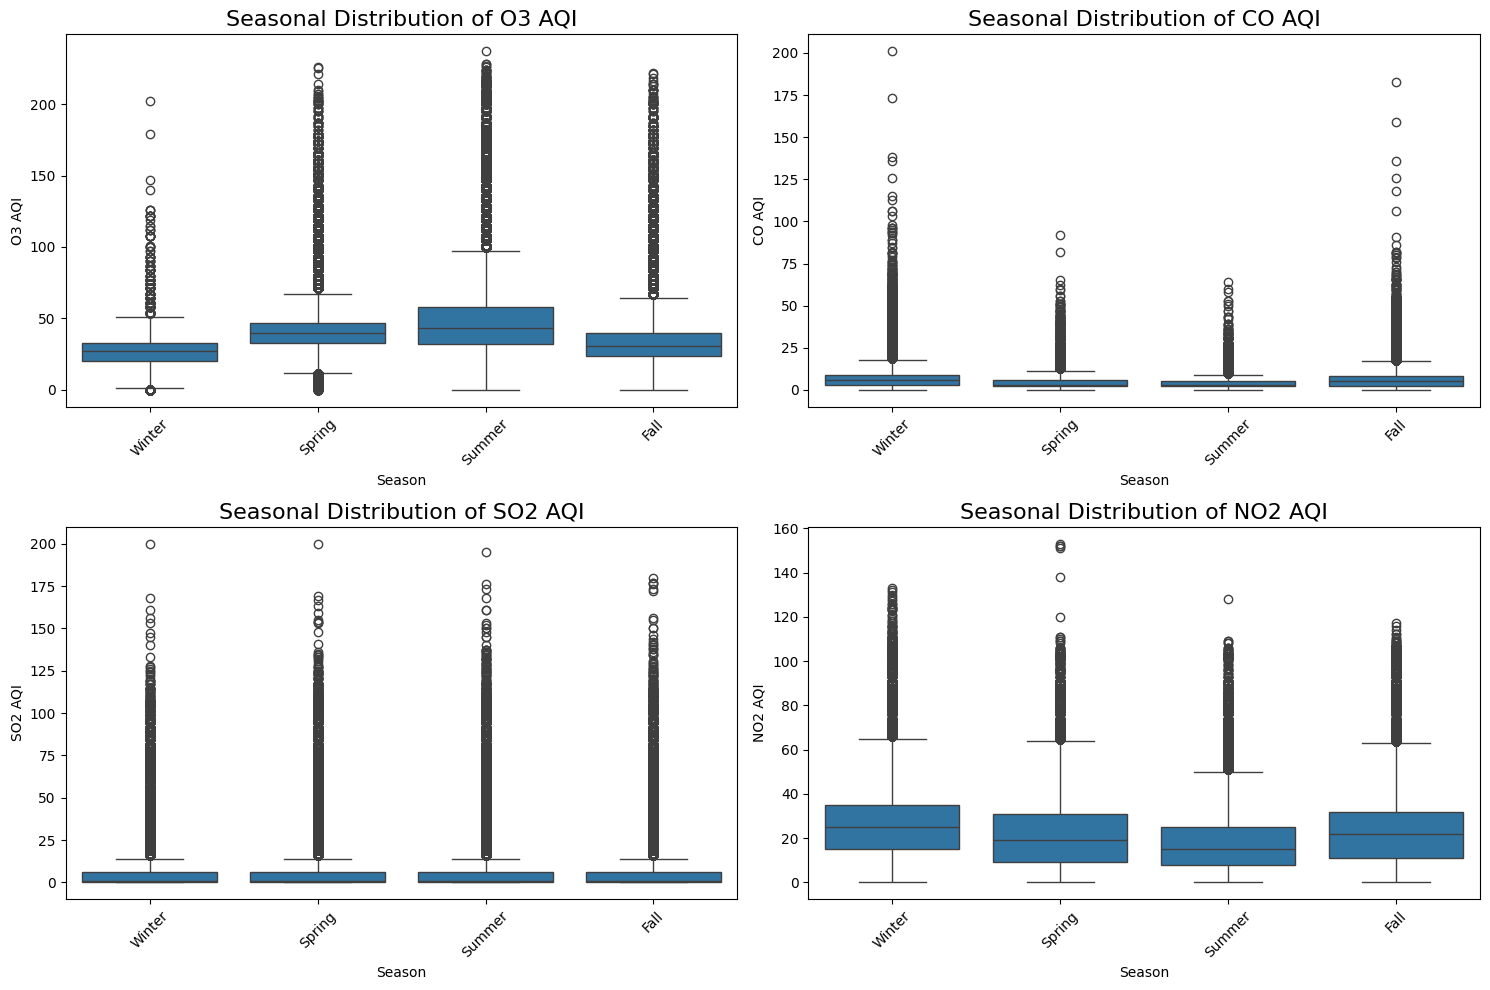

State
Alabama                 38.189610
Alaska                  19.052111
Arizona                 44.628593
Arkansas                36.748515
California              39.924624
Colorado                39.611989
Connecticut             38.987226
Delaware                36.439232
District Of Columbia    37.939907
Florida                 38.461776
Georgia                 35.984329
Hawaii                  27.095087
Idaho                   38.559079
Illinois                35.838948
Indiana                 41.974210
Iowa                    34.914837
Kansas                  37.320463
Kentucky                44.491146
Louisiana               36.637783
Maine                   29.879718
Maryland                38.861302
Massachusetts           28.695687
Michigan                42.714582
Minnesota               35.225727
Mississippi             34.002037
Missouri                41.755309
Nevada                  43.876495
New Hampshire           36.981843
New Jersey              36.138157
New Mexi

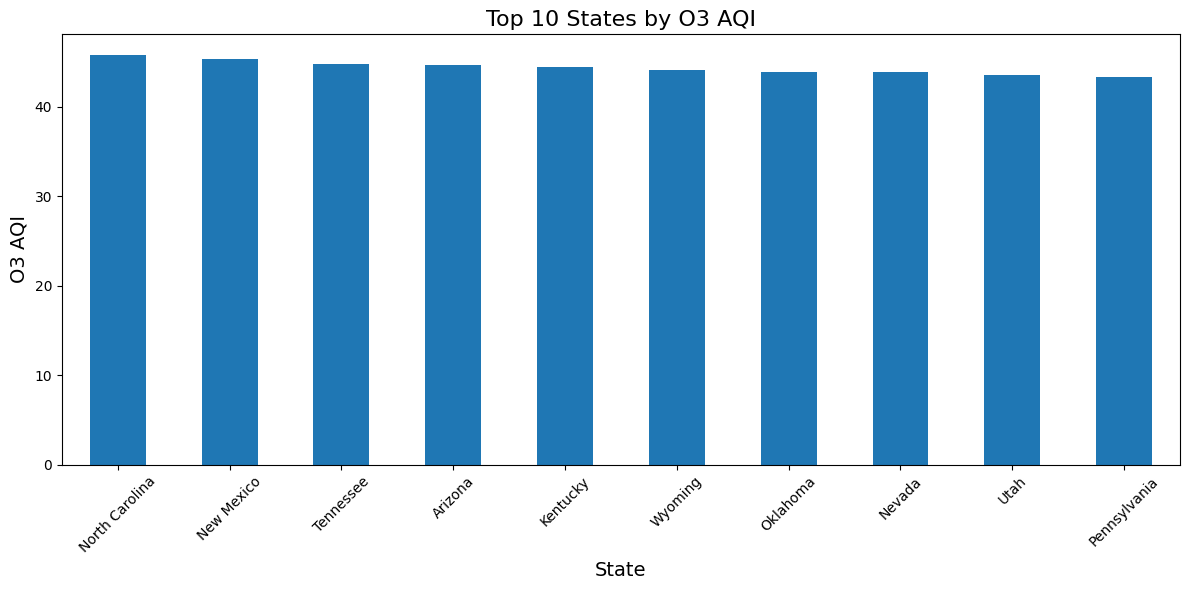

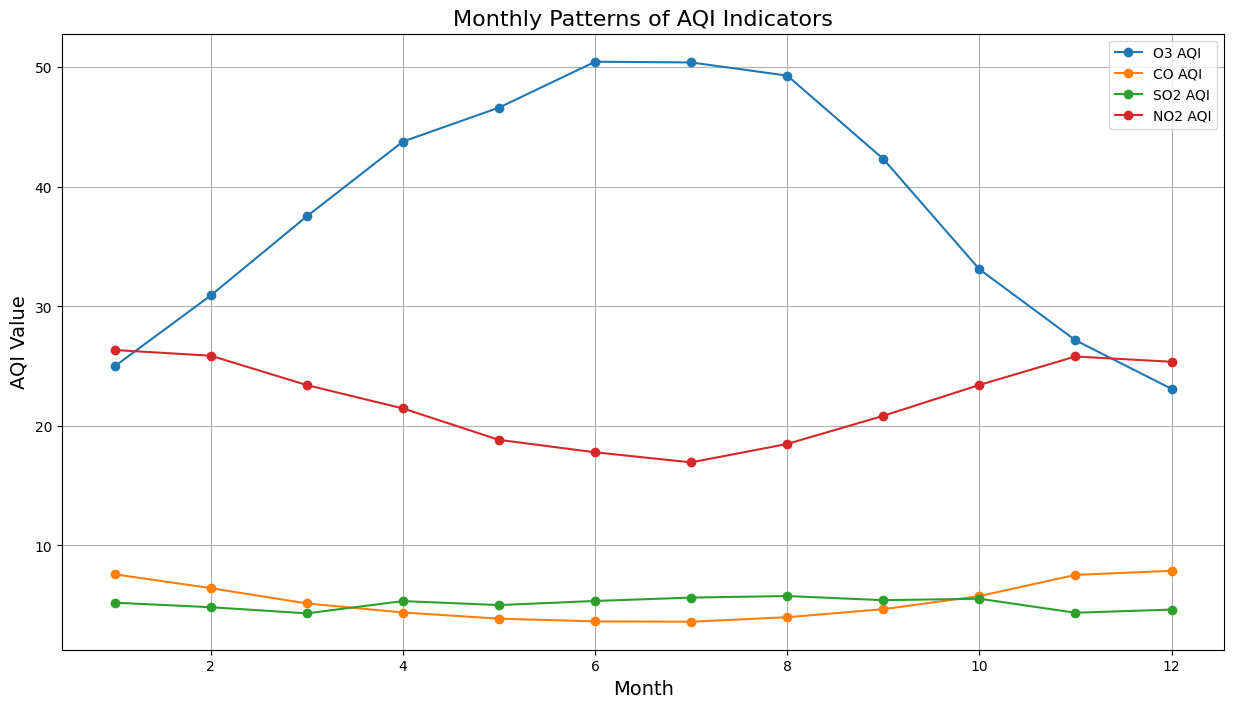

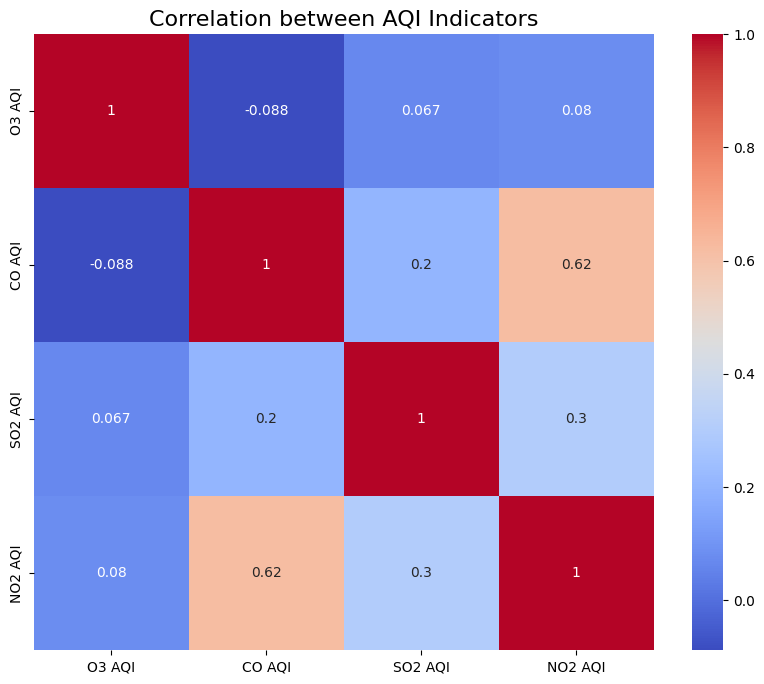

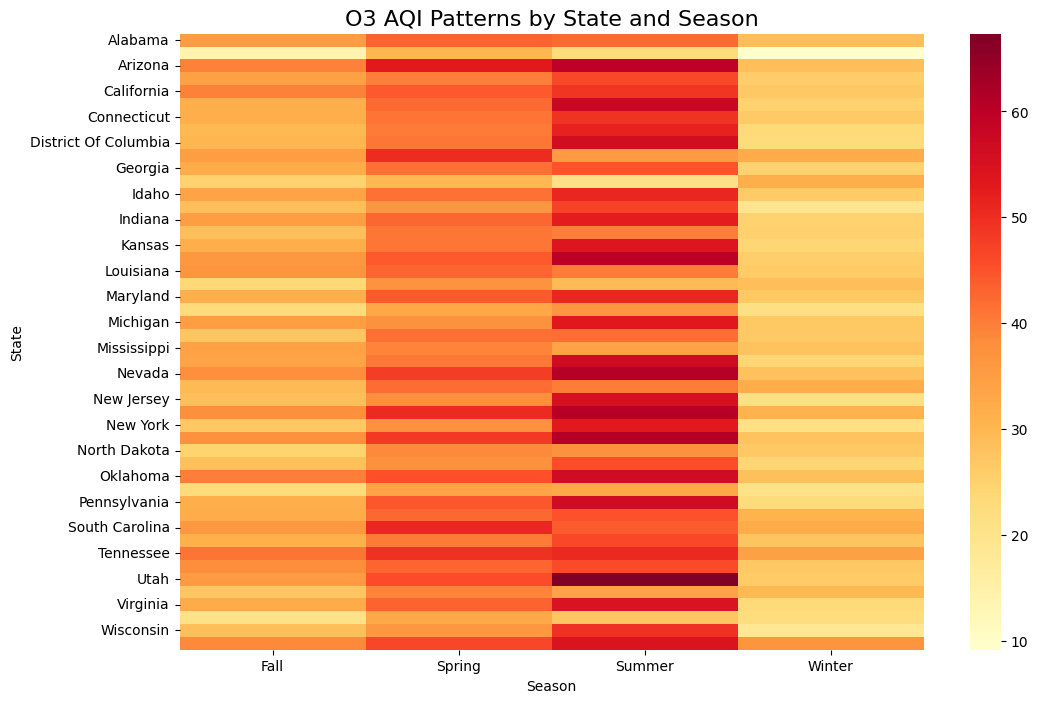

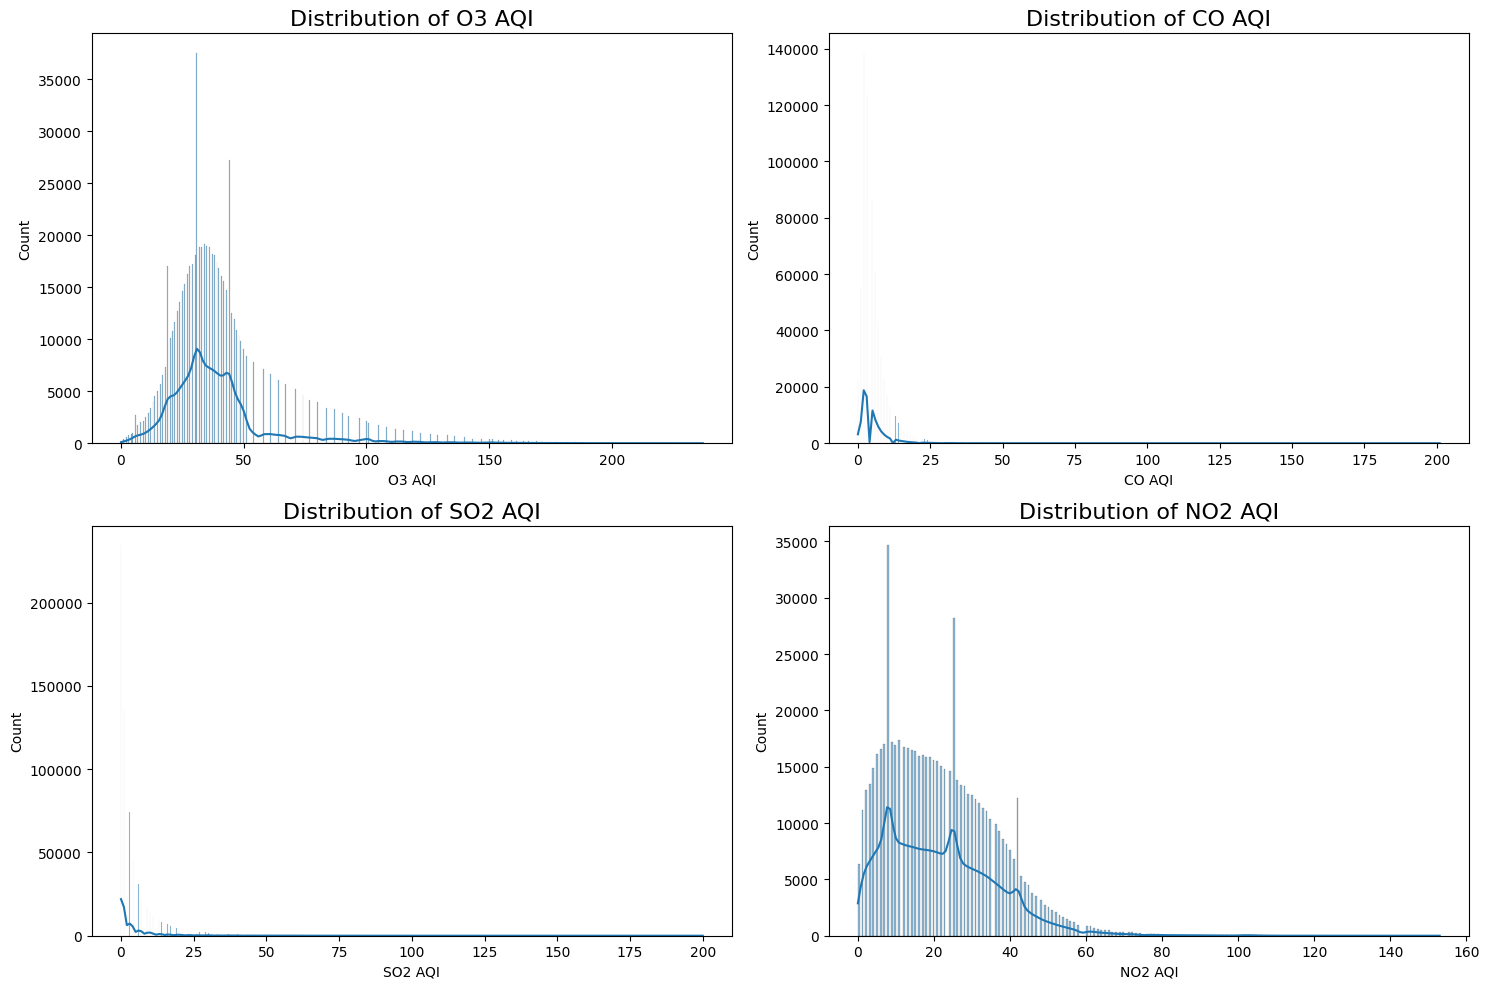

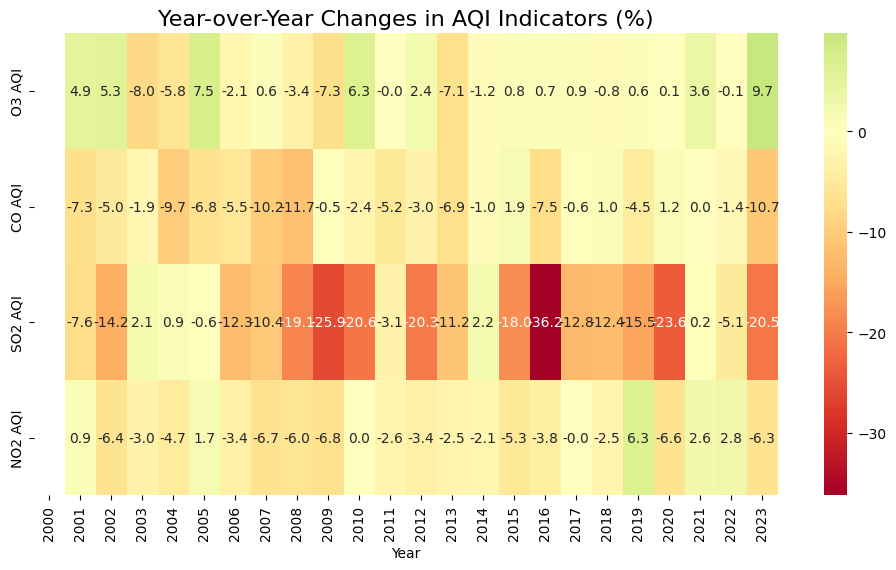


statistical summary of aqi indicators:
              O3 AQI         CO AQI        SO2 AQI        NO2 AQI
count  665414.000000  665414.000000  665414.000000  665414.000000
mean       39.137872       5.247399       5.154743      21.766209
std        22.253413       5.010467      10.371465      14.447780
min         0.000000       0.000000       0.000000       0.000000
25%        27.000000       2.000000       0.000000      10.000000
50%        35.000000       3.000000       1.000000      20.000000
75%        44.000000       7.000000       6.000000      31.000000
max       237.000000     201.000000     200.000000     153.000000

states with highest aqi readings:

Highest O3 AQI:
State: California
Value: 237
Date: 2003-08-17 00:00:00

Highest CO AQI:
State: California
Value: 201.0
Date: 2000-12-20 00:00:00

Highest SO2 AQI:
State: Illinois
Value: 200.0
Date: 2002-02-14 00:00:00

Highest NO2 AQI:
State: New Mexico
Value: 153
Date: 2023-04-07 00:00:00


/var/folders/5j/c37p3_194zl99prh3p0f64t40000gn/T/ipykernel_83188/3575951671.py:126: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_o3.index = pd.date_range(start=f"{monthly_o3['Year'].min()}",


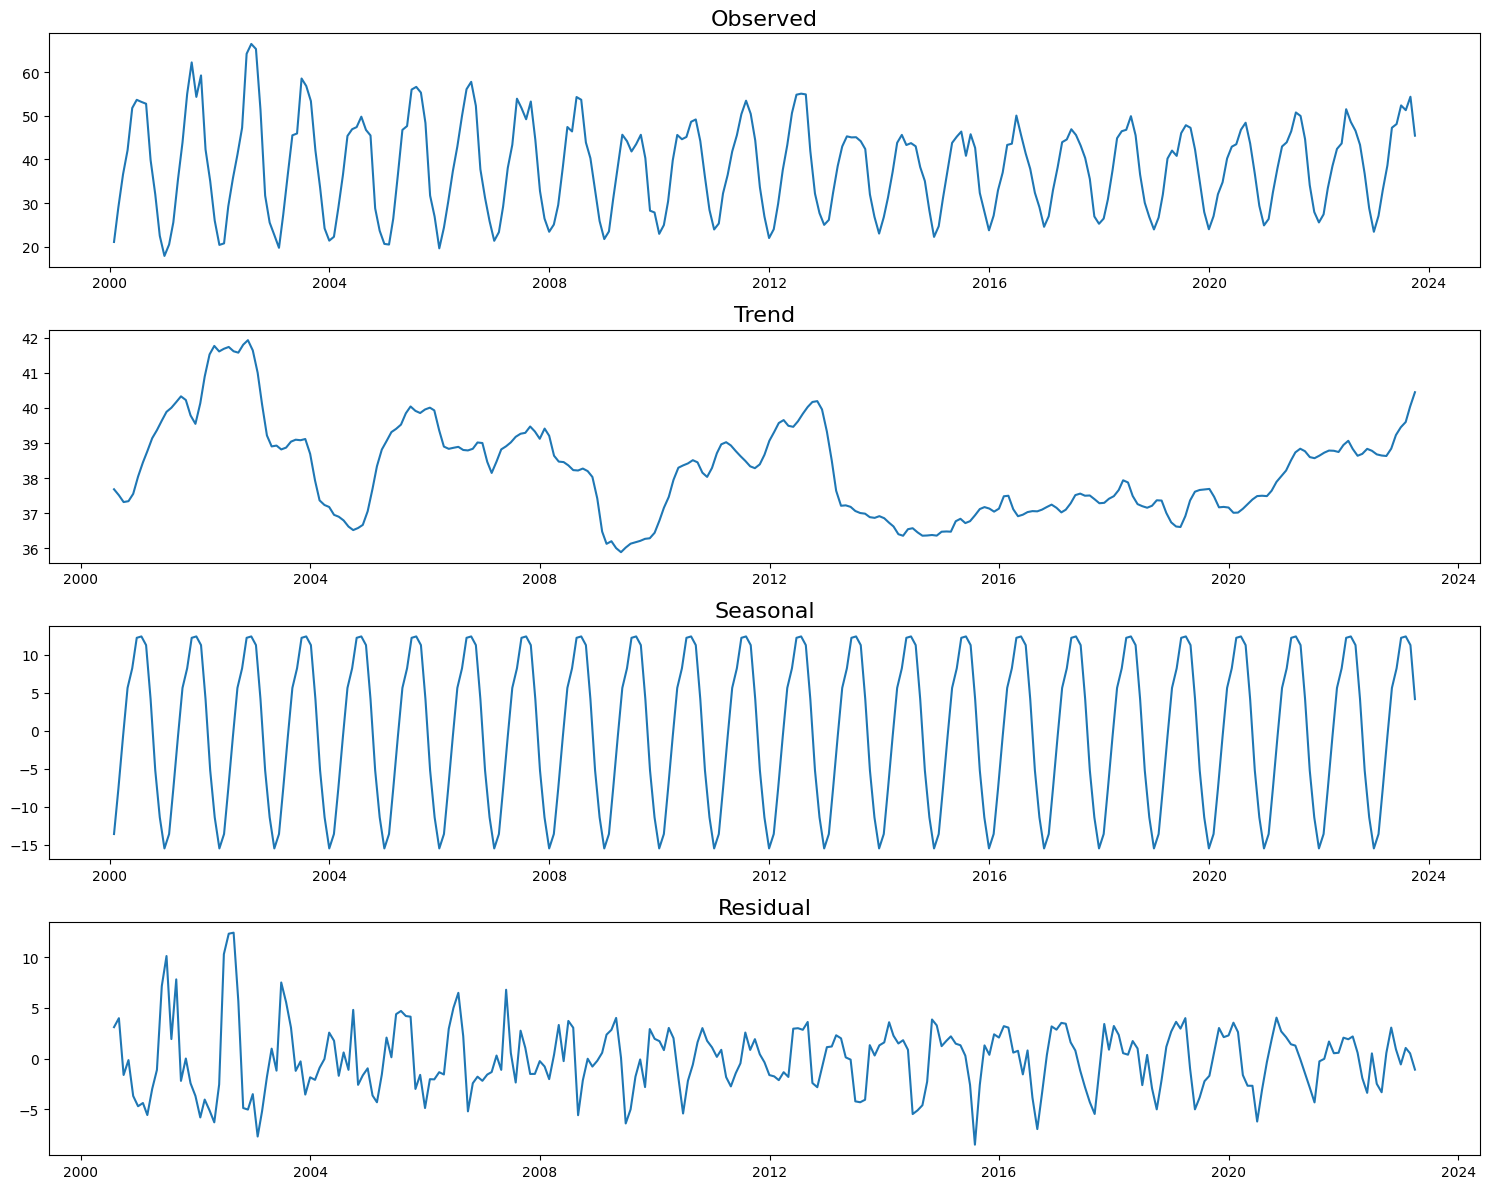


percentage of days exceeding aqi thresholds by state:
                  O3 AQI  CO AQI   SO2 AQI   NO2 AQI
North Carolina  4.962281     0.0  0.228390  0.000000
Pennsylvania    4.911160     0.0  0.476525  0.014776
Michigan        4.733932     0.0  1.313062  0.034554
Kentucky        4.459111     0.0  0.450741  0.000000
Missouri        4.050554     0.0  0.134673  0.000000


In [32]:

conn = sqlite3.connect('data/data.db')

pollution_df = pd.read_sql_query("SELECT * FROM pollution", conn)

conn.close()

# load and prepare aqi data
pollution_df['Date'] = pd.to_datetime(pollution_df['Date'])
pollution_df['Year'] = pollution_df['Date'].dt.year
pollution_df['Month'] = pollution_df['Date'].dt.month
pollution_df['Season'] = pollution_df['Date'].dt.month.map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

# list of aqi columns
aqi_columns = ['O3 AQI', 'CO AQI', 'SO2 AQI', 'NO2 AQI']

# 2. overall aqi trends
plt.figure(figsize=(15, 8))
for aqi in aqi_columns:
    yearly_avg = pollution_df.groupby('Year')[aqi].mean()
    plt.plot(yearly_avg.index, yearly_avg.values, marker='o', label=aqi)
plt.title('Yearly Trends of Different AQI Indicators', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('AQI Value', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# 3. seasonal patterns
plt.figure(figsize=(15, 10))
for i, aqi in enumerate(aqi_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=pollution_df, x='Season', y=aqi)
    plt.title(f'Seasonal Distribution of {aqi}', fontsize=16)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. state-wise analysis
# average aqi by state
state_o3_aqi = pollution_df.groupby('State')['O3 AQI'].mean()
print(state_o3_aqi)
top_10_states = state_o3_aqi.sort_values(ascending=False).head(10)
print(top_10_states)
plt.figure(figsize=(12, 6))
top_10_states.plot(kind='bar')
plt.title('Top 10 States by O3 AQI', fontsize=16)
plt.xlabel('State', fontsize=14)
plt.ylabel('O3 AQI', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. monthly patterns
plt.figure(figsize=(15, 8))
for aqi in aqi_columns:
    monthly_avg = pollution_df.groupby('Month')[aqi].mean()
    plt.plot(monthly_avg.index, monthly_avg.values, marker='o', label=aqi)
plt.title('Monthly Patterns of AQI Indicators', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('AQI Value', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# 6. correlation analysis
plt.figure(figsize=(10, 8))
sns.heatmap(pollution_df[aqi_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation between AQI Indicators', fontsize=16)
plt.show()

# 7. state-wise seasonal analysis
# create a pivot table for state and season
seasonal_state = pollution_df.pivot_table(
    values=aqi_columns,
    index=['State'],
    columns=['Season'],
    aggfunc='mean'
)

# plot heatmap for one aqi indicator
plt.figure(figsize=(12, 8))
sns.heatmap(seasonal_state['O3 AQI'], cmap='YlOrRd')
plt.title('O3 AQI Patterns by State and Season', fontsize=16)
plt.show()

# 8. distribution analysis
plt.figure(figsize=(15, 10))
for i, aqi in enumerate(aqi_columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data=pollution_df, x=aqi, kde=True)
    plt.title(f'Distribution of {aqi}', fontsize=16)
plt.tight_layout()
plt.show()

# 9. year-over-year changes
yoy_changes = pollution_df.groupby('Year')[aqi_columns].mean().pct_change() * 100

plt.figure(figsize=(12, 6))
sns.heatmap(yoy_changes.T, cmap='RdYlGn', center=0, annot=True, fmt='.1f')
plt.title('Year-over-Year Changes in AQI Indicators (%)', fontsize=16)
plt.show()

# 10. statistical summary
print("\nstatistical summary of aqi indicators:")
print(pollution_df[aqi_columns].describe())

# 11. extreme value analysis
print("\nstates with highest aqi readings:")
for aqi in aqi_columns:
    max_aqi = pollution_df.loc[pollution_df[aqi].idxmax()]
    print(f"\nHighest {aqi}:")
    print(f"State: {max_aqi['State']}")
    print(f"Value: {max_aqi[aqi]}")
    print(f"Date: {max_aqi['Date']}")

# 12. time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# example for o3 aqi
monthly_o3 = pollution_df.groupby(['Year', 'Month'])['O3 AQI'].mean().reset_index()
monthly_o3.index = pd.date_range(start=f"{monthly_o3['Year'].min()}", 
                                periods=len(monthly_o3), 
                                freq='M')

decomposition = seasonal_decompose(monthly_o3['O3 AQI'], period=12)

plt.figure(figsize=(15, 12))
plt.subplot(411)
plt.plot(decomposition.observed)
plt.title('Observed', fontsize=16)
plt.subplot(412)
plt.plot(decomposition.trend)
plt.title('Trend', fontsize=16)
plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.title('Seasonal', fontsize=16)
plt.subplot(414)
plt.plot(decomposition.resid)
plt.title('Residual', fontsize=16)
plt.tight_layout()
plt.show()

# 13. critical threshold analysis
threshold_values = {
    'O3 AQI': 100,
    'CO AQI': 100,
    'SO2 AQI': 100,
    'NO2 AQI': 100
}

exceedance_by_state = {}
for state in pollution_df['State'].unique():
    state_data = pollution_df[pollution_df['State'] == state]
    exceedances = {}
    for aqi in aqi_columns:
        exceedances[aqi] = (state_data[aqi] > threshold_values[aqi]).mean() * 100
    exceedance_by_state[state] = exceedances

exceedance_df = pd.DataFrame(exceedance_by_state).T
print("\npercentage of days exceeding aqi thresholds by state:")
print(exceedance_df.sort_values('O3 AQI', ascending=False).head())

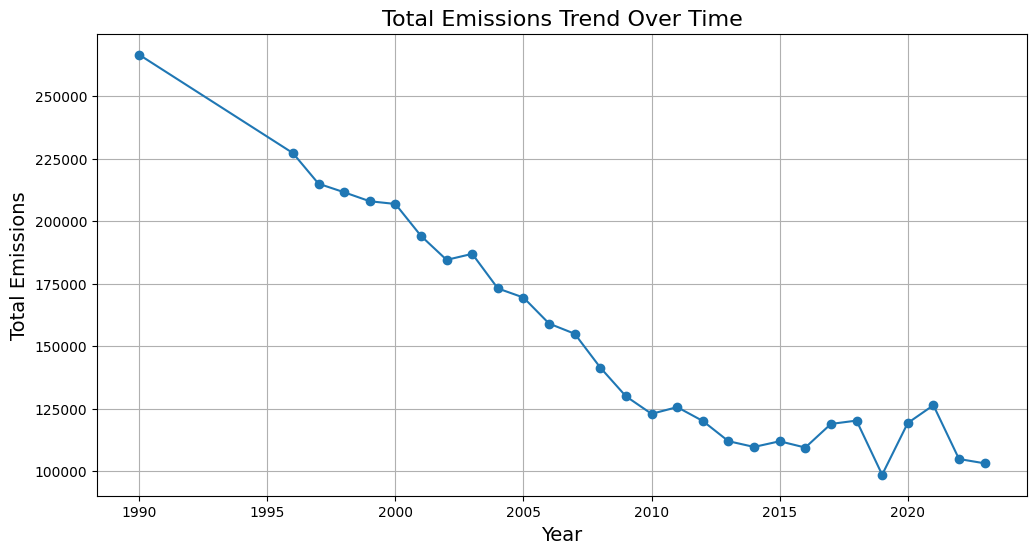

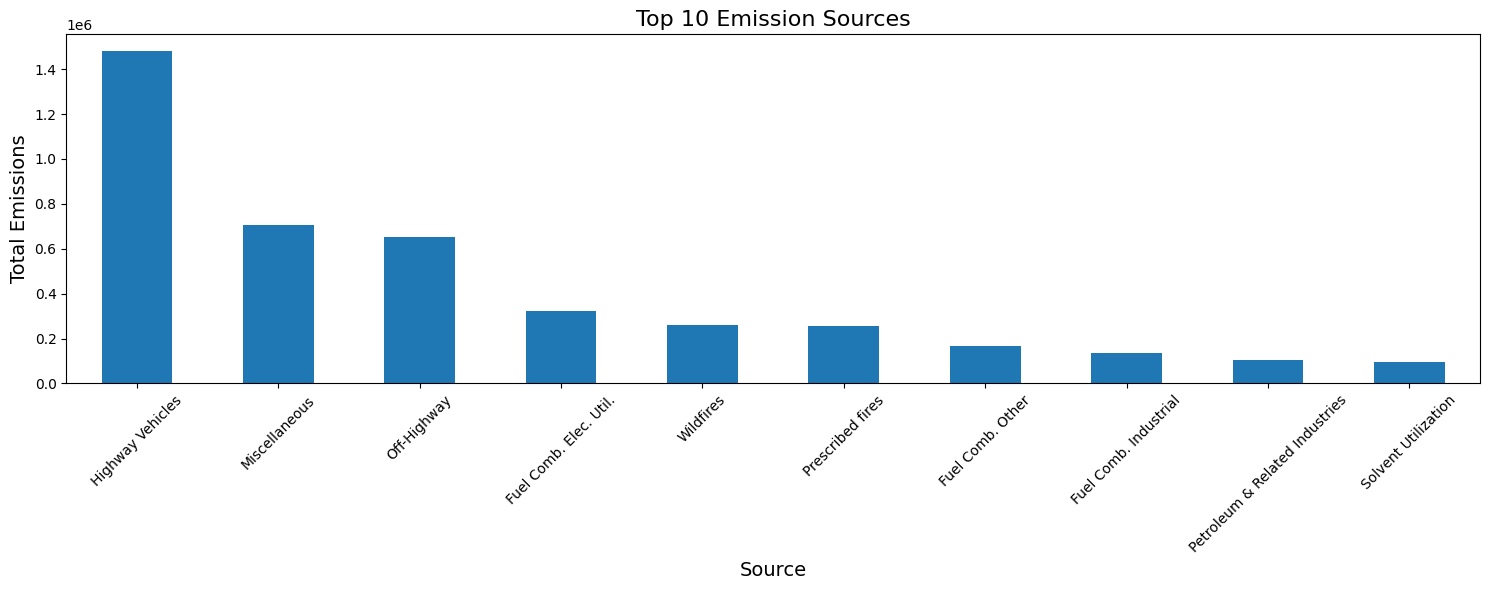

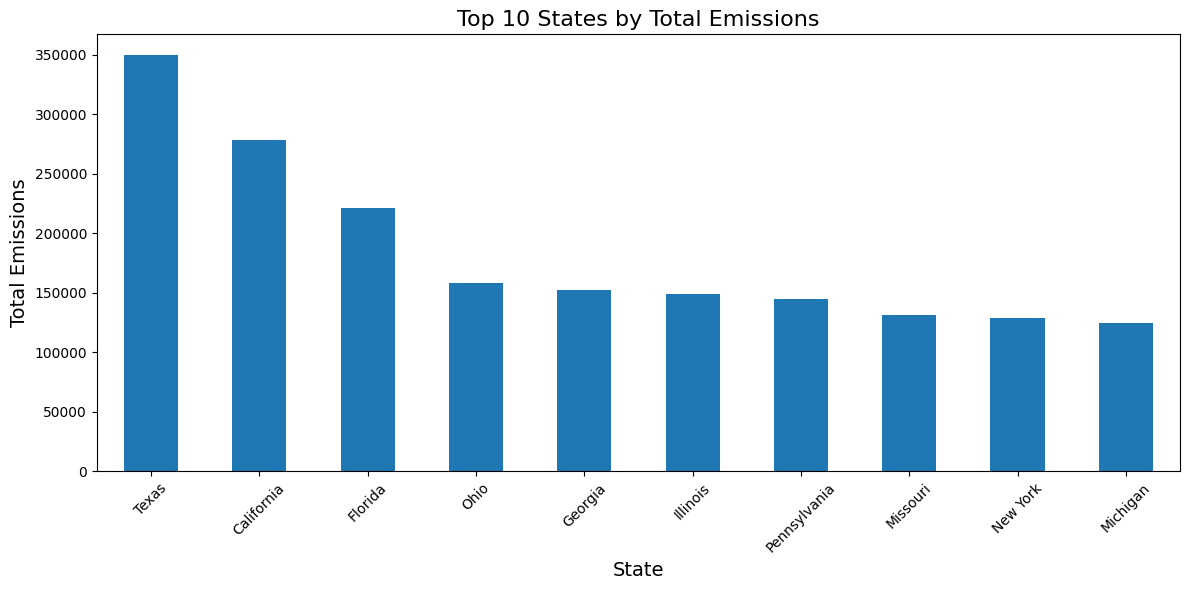

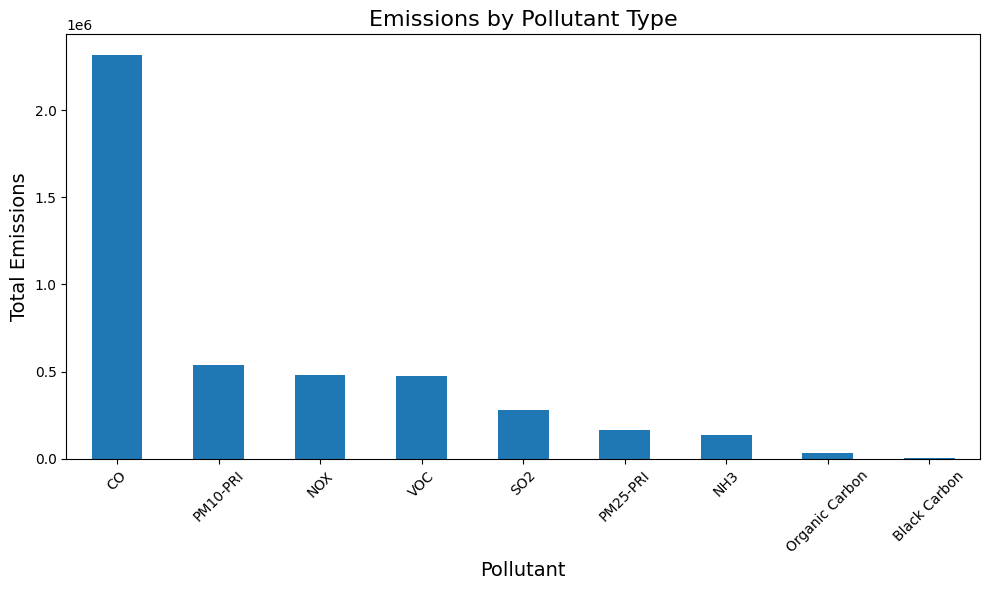

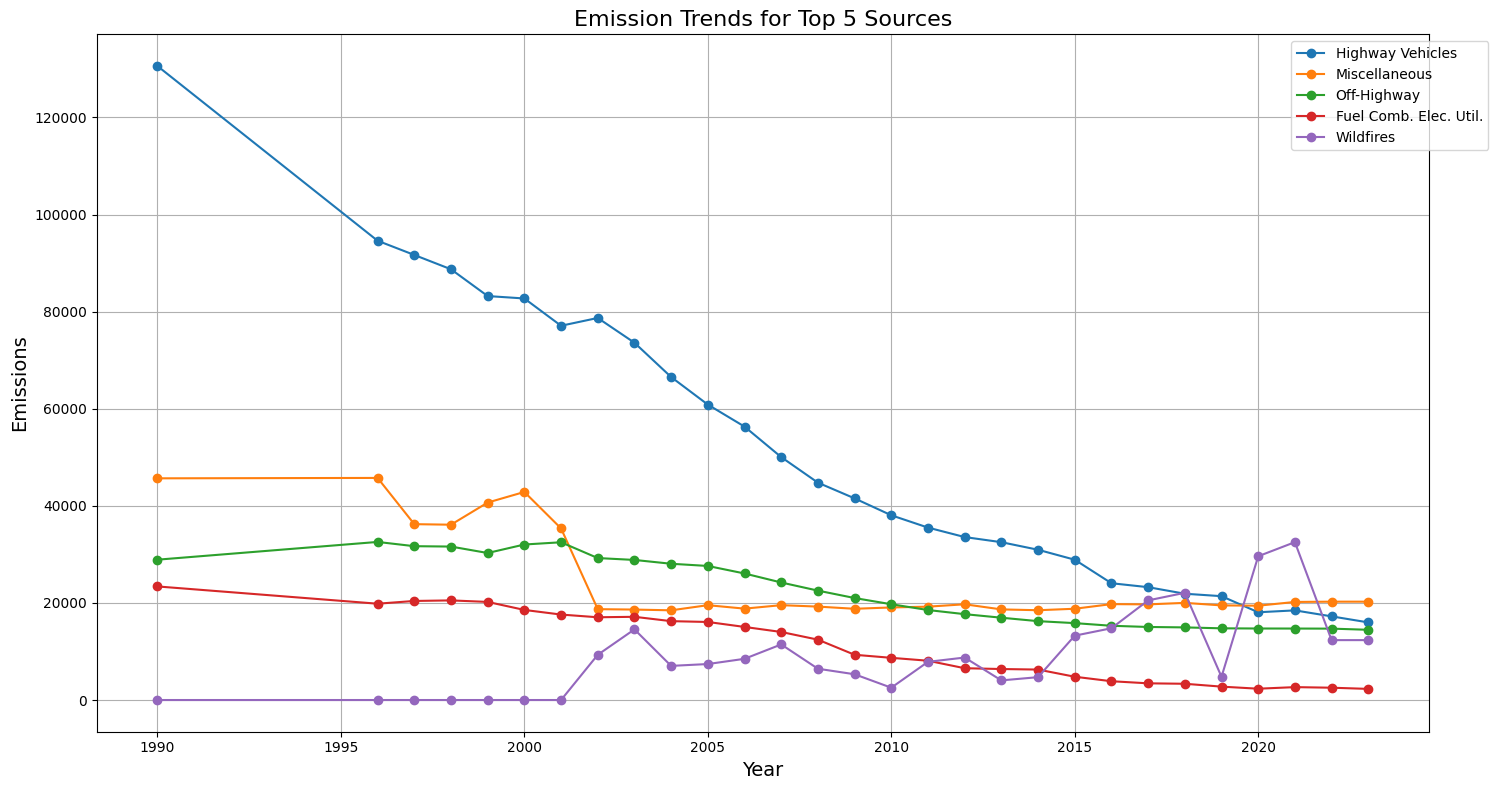

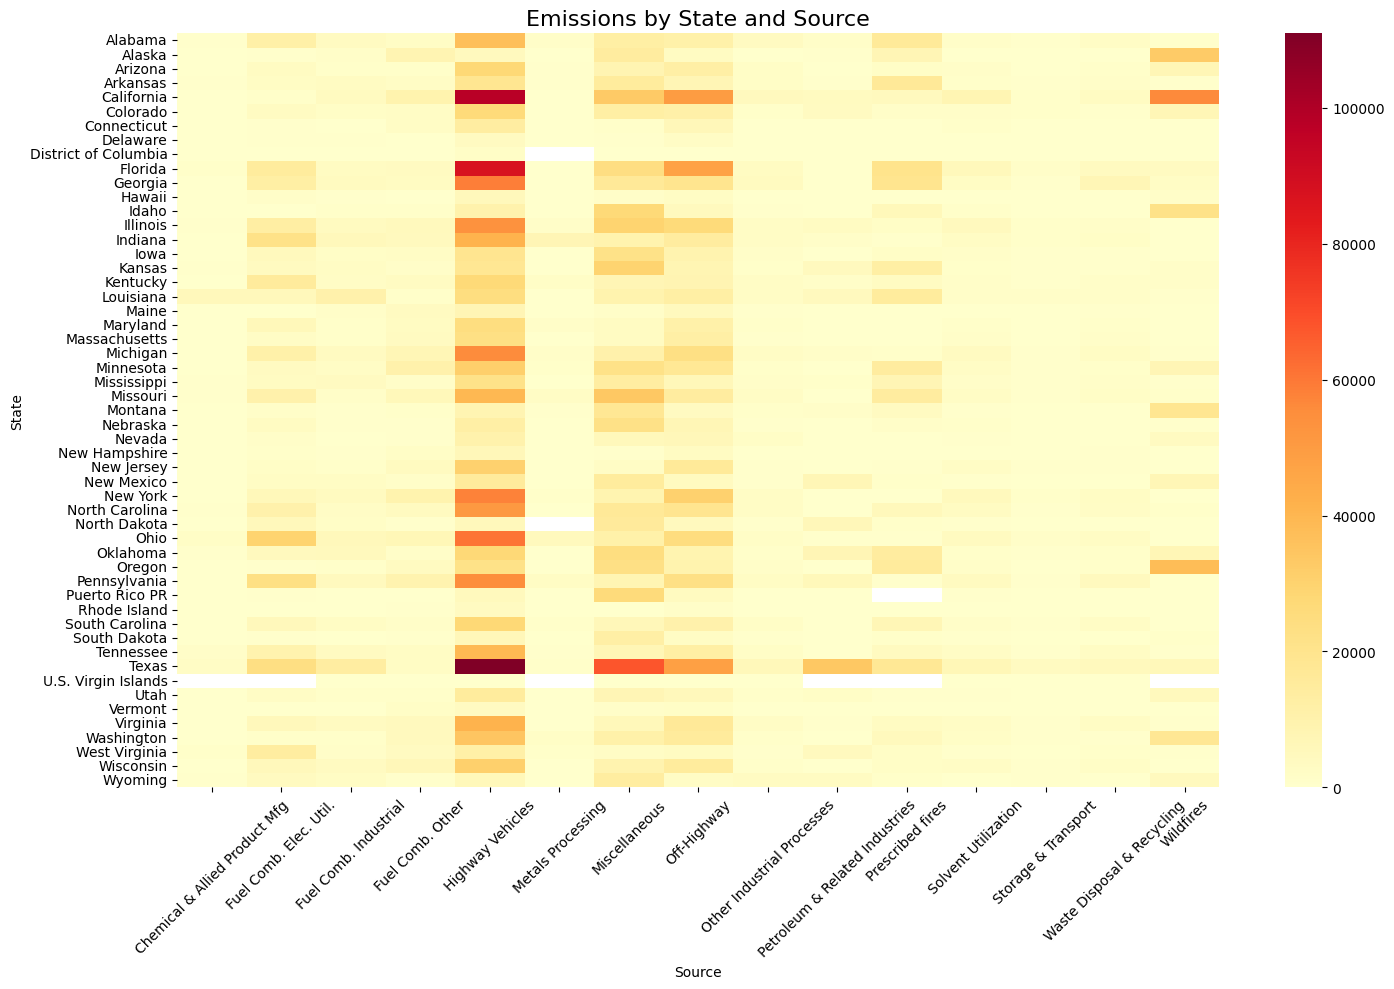

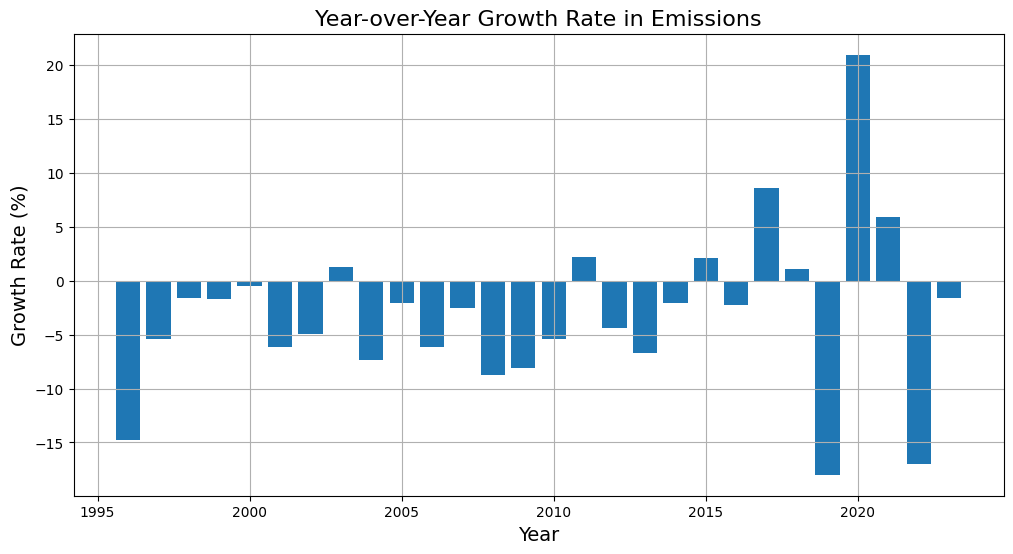

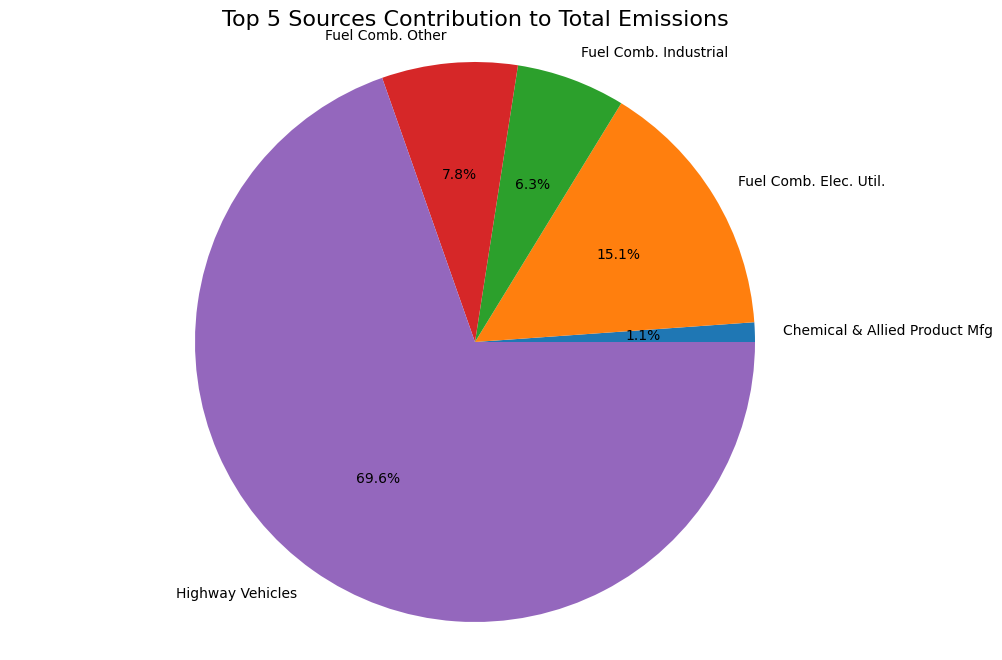


Emissions Statistics by Source:
                                       sum    mean     std
Source                                                    
Highway Vehicles                1480932.66  105.51  392.81
Miscellaneous                    707535.69   50.20  154.81
Off-Highway                      650921.84   46.18  149.45
Fuel Comb. Elec. Util.           321915.34   23.32   89.41
Wildfires                        260165.00   19.17  161.80
Prescribed fires                 257261.08   19.54   75.42
Fuel Comb. Other                 166834.01   11.84   27.38
Fuel Comb. Industrial            133956.61    9.50   23.45
Petroleum & Related Industries   104120.09    7.61   46.49
Solvent Utilization               97378.76    7.05   29.64


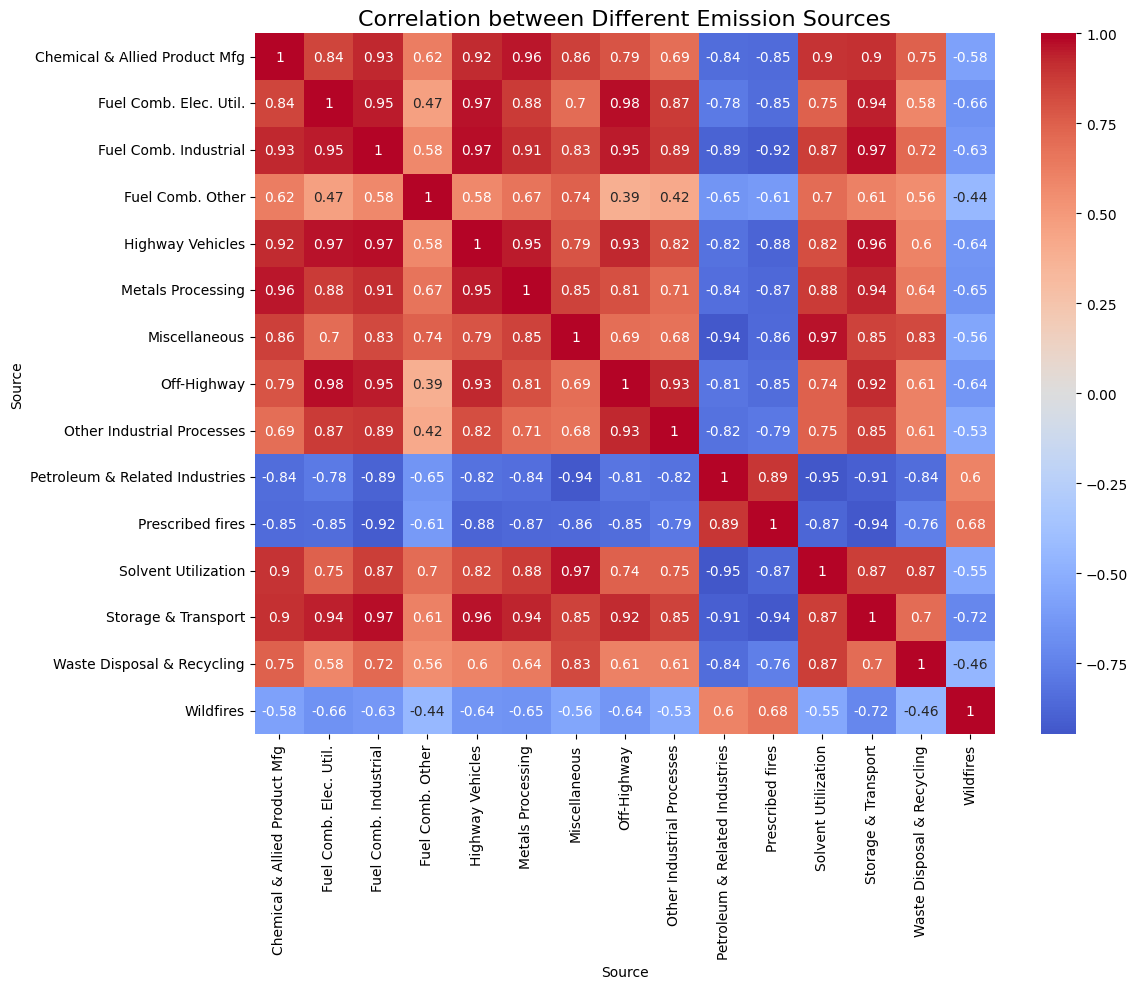

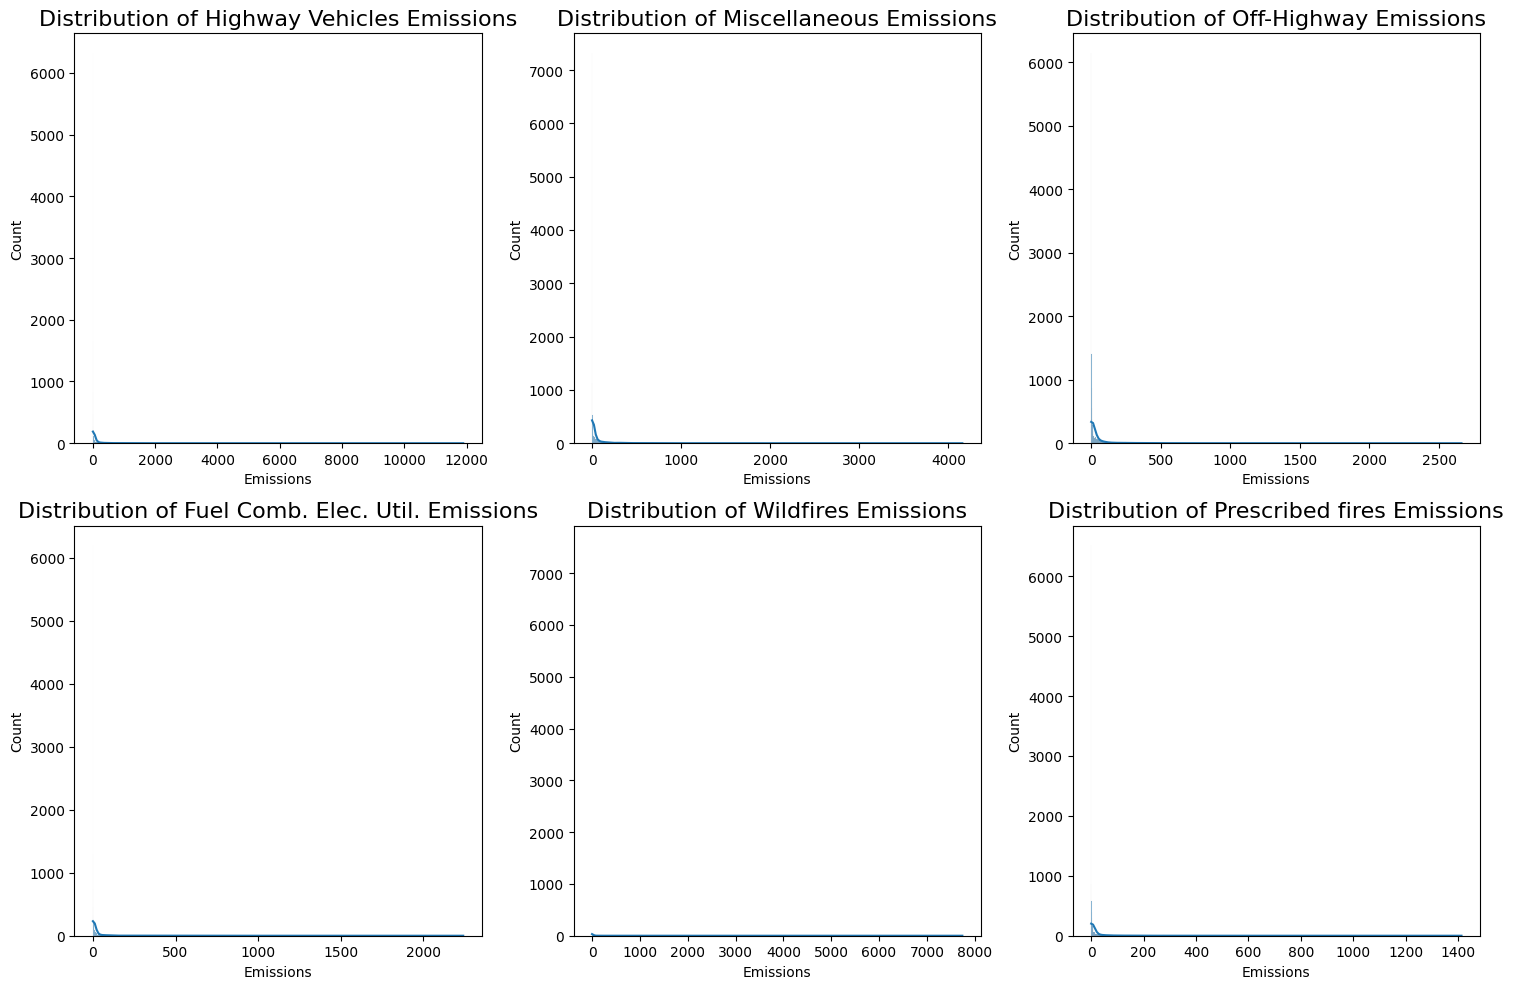


key insights:
1. total emissions change: -61.28%
2. most polluting state: Texas
3. Top Emission Source: Highway Vehicles
4. Average Annual Growth Rate: -3.05%


In [33]:
from scipy import stats

conn = sqlite3.connect('data/data.db')

emissions_df = pd.read_sql_query("SELECT * FROM emissions", conn)


conn.close()

# 2. overall emissions trend
yearly_emissions = emissions_df.groupby('Year')['Emissions'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(yearly_emissions['Year'], yearly_emissions['Emissions'], marker='o')
plt.title('Total Emissions Trend Over Time', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Emissions', fontsize=14)
plt.grid(True)
plt.show()

# 3. source-wise analysis
# total emissions by source
source_emissions = emissions_df.groupby('Source')['Emissions'].agg(['sum', 'mean', 'std']).round(2)
source_emissions = source_emissions.sort_values('sum', ascending=False)

# plot top 10 emission sources
plt.figure(figsize=(15, 6))
source_emissions['sum'].head(10).plot(kind='bar')
plt.title('Top 10 Emission Sources', fontsize=16)
plt.xlabel('Source', fontsize=14)
plt.ylabel('Total Emissions', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. state-wise analysis
state_emissions = emissions_df.groupby('State')['Emissions'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
state_emissions.head(10).plot(kind='bar')
plt.title('Top 10 States by Total Emissions', fontsize=16)
plt.xlabel('State', fontsize=14)
plt.ylabel('Total Emissions', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. pollutant-wise analysis
pollutant_emissions = emissions_df.groupby('Pollutant')['Emissions'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
pollutant_emissions.plot(kind='bar')
plt.title('Emissions by Pollutant Type', fontsize=16)
plt.xlabel('Pollutant', fontsize=14)
plt.ylabel('Total Emissions', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6. time series analysis by source
plt.figure(figsize=(15, 8))
for source in source_emissions.head(5).index:  # Top 5 sources
    source_data = emissions_df[emissions_df['Source'] == source].groupby('Year')['Emissions'].sum()
    plt.plot(source_data.index, source_data.values, marker='o', label=source)
plt.title('Emission Trends for Top 5 Sources', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Emissions', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. state and source combined analysis
state_source_emissions = emissions_df.pivot_table(
    values='Emissions',
    index='State',
    columns='Source',
    aggfunc='sum'
)

plt.figure(figsize=(15, 10))
sns.heatmap(state_source_emissions, cmap='YlOrRd')
plt.title('Emissions by State and Source', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 8. growth rate analysis
yearly_growth = yearly_emissions.set_index('Year')['Emissions'].pct_change() * 100

plt.figure(figsize=(12, 6))
plt.bar(yearly_growth.index, yearly_growth.values)
plt.title('Year-over-Year Growth Rate in Emissions', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Growth Rate (%)', fontsize=14)
plt.grid(True)
plt.show()

# 9. source contribution analysis
source_contribution = emissions_df.groupby('Source')['Emissions'].sum()
total_emissions = source_contribution.sum()
source_percentage = (source_contribution / total_emissions * 100).round(2)

plt.figure(figsize=(12, 8))
plt.pie(source_percentage.head(5), labels=source_percentage.head(5).index, autopct='%1.1f%%')
plt.title('Top 5 Sources Contribution to Total Emissions', fontsize=16)
plt.axis('equal')
plt.show()

# 10. statistical analysis
print("\nEmissions Statistics by Source:")
print(source_emissions.head(10))

# 11. correlation analysis
# create pivot table for correlation analysis
source_year_pivot = emissions_df.pivot_table(
    values='Emissions',
    index='Year',
    columns='Source',
    aggfunc='sum'
)

plt.figure(figsize=(12, 10))
sns.heatmap(source_year_pivot.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Different Emission Sources', fontsize=16)
plt.tight_layout()
plt.show()


# 12. source distribution analysis
plt.figure(figsize=(15, 10))
for i, source in enumerate(source_emissions.head(6).index, 1):
    plt.subplot(2, 3, i)
    source_data = emissions_df[emissions_df['Source'] == source]['Emissions']
    sns.histplot(source_data, kde=True)
    plt.title(f'Distribution of {source} Emissions', fontsize=16)
plt.tight_layout()
plt.show()

# 13. key insights summary
print("\nkey insights:")
print(f"1. total emissions change: {((yearly_emissions.iloc[-1]['Emissions'] / yearly_emissions.iloc[0]['Emissions'] - 1) * 100):.2f}%")
print(f"2. most polluting state: {state_emissions.index[0]}")
print(f"3. Top Emission Source: {source_emissions.index[0]}")
print(f"4. Average Annual Growth Rate: {yearly_growth.mean():.2f}%")

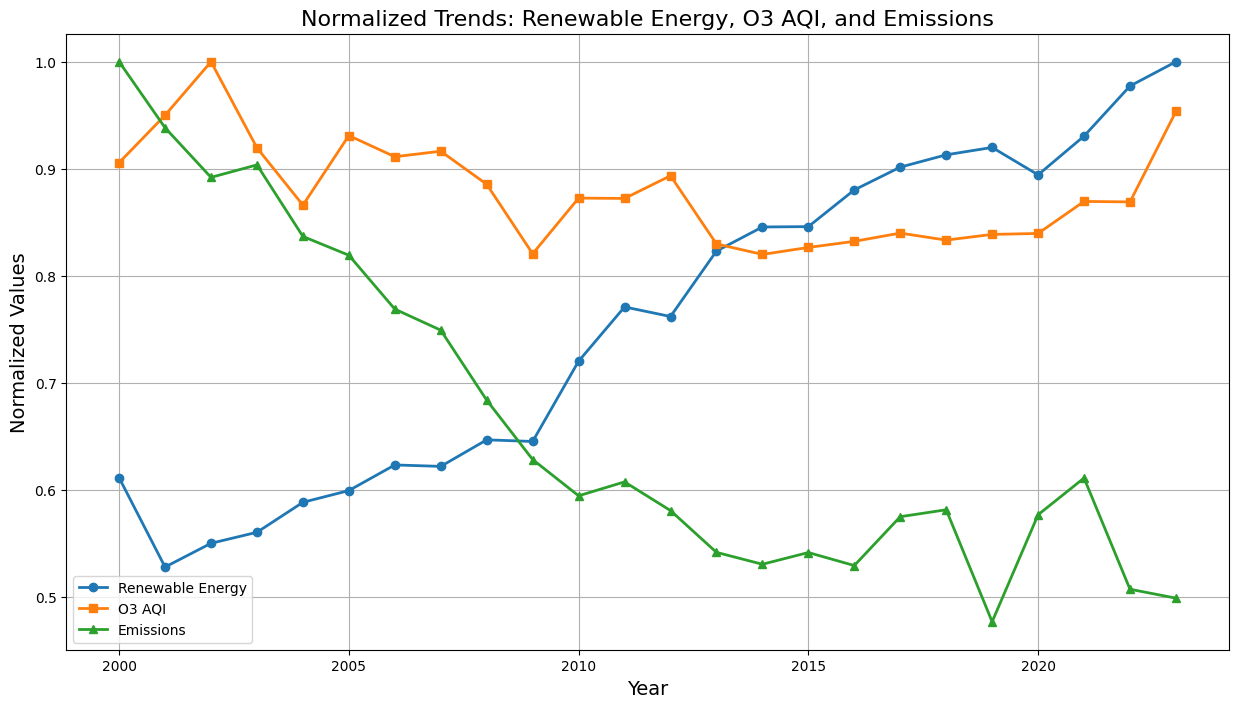

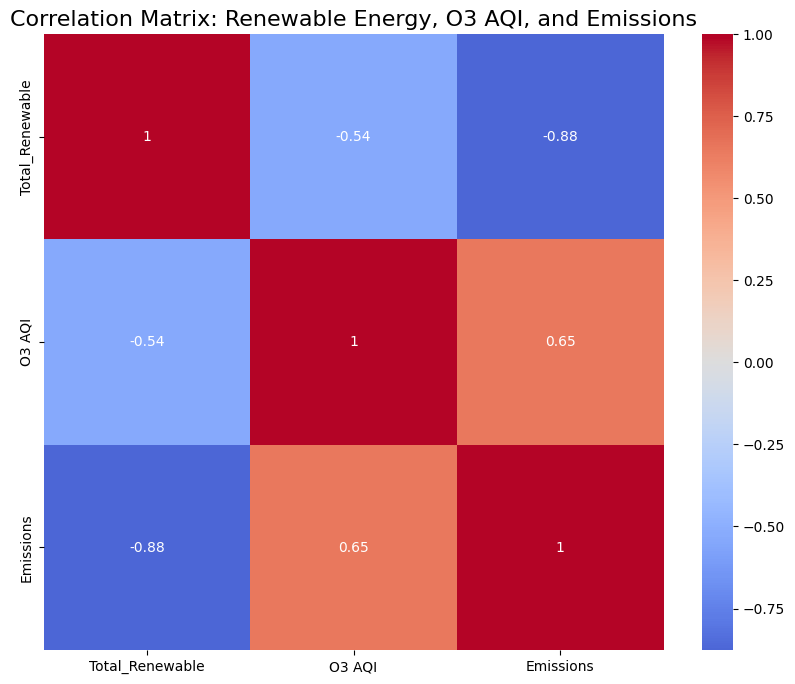

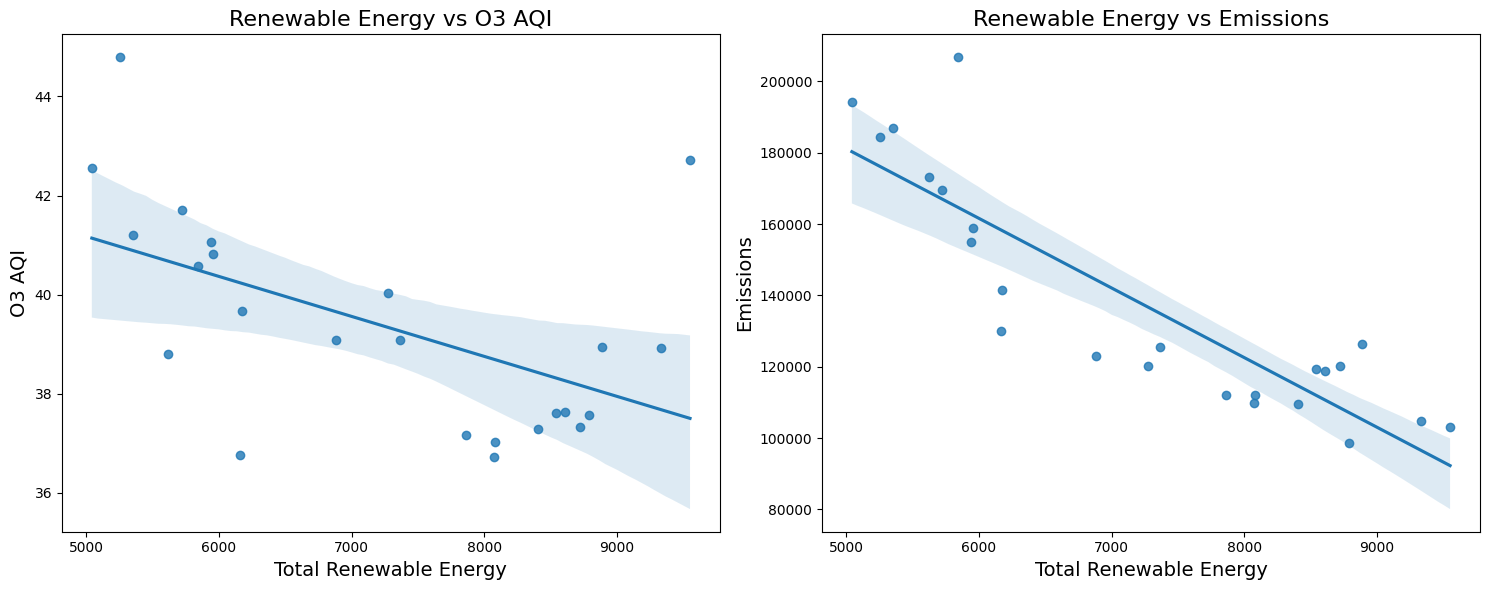

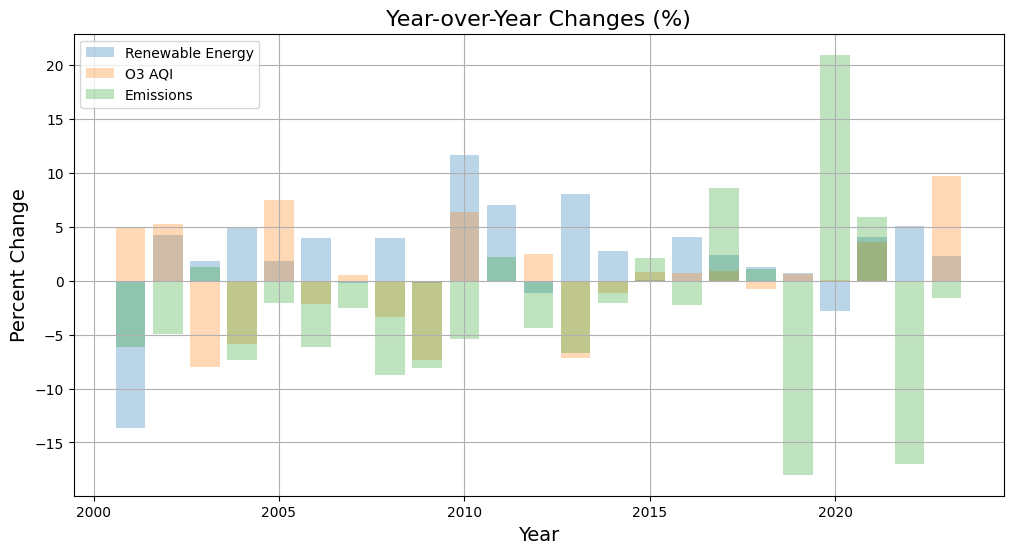

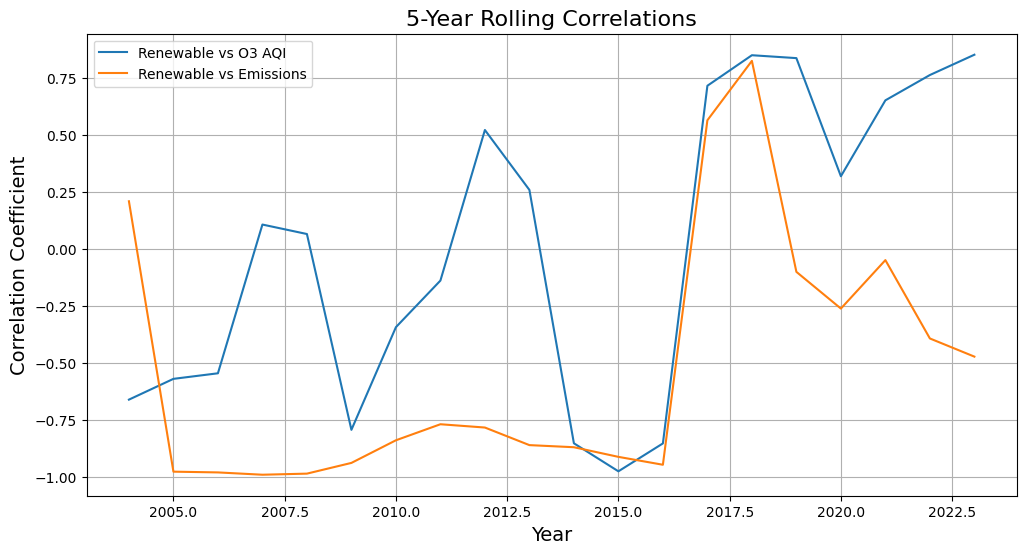


statistical analysis:
renewable energy vs o3 aqi correlation: -0.539 (p-value: 0.007)
renewable energy vs emissions correlation: -0.877 (p-value: 0.000)

key findings:
1. correlation between renewable energy and o3 aqi: -0.539
2. correlation between renewable energy and emissions: -0.877
3. correlation between o3 aqi and emissions: 0.654

total changes (2000-2023):
renewable energy: 63.6%
o3 aqi: 5.3%
emissions: -50.1%


In [34]:
# 1. prepare combined dataset
# all datasets are at the same temporal granularity (yearly)
yearly_renewable = renewable_df.groupby('Year')['Total_Renewable'].sum().reset_index()
yearly_o3_aqi = pollution_df.groupby('Year')['O3 AQI'].mean().reset_index()
yearly_emissions = emissions_df.groupby('Year')['Emissions'].sum().reset_index()

# merge the datasets
combined_df = pd.merge(yearly_renewable, yearly_o3_aqi, on='Year', how='inner')
combined_df = pd.merge(combined_df, yearly_emissions, on='Year', how='inner')

# 2. overall trend comparison
plt.figure(figsize=(15, 8))
# normalize the values for comparison
combined_df['Normalized_Renewable'] = combined_df['Total_Renewable'] / combined_df['Total_Renewable'].max()
combined_df['Normalized_O3'] = combined_df['O3 AQI'] / combined_df['O3 AQI'].max()
combined_df['Normalized_Emissions'] = combined_df['Emissions'] / combined_df['Emissions'].max()

plt.plot(combined_df['Year'], combined_df['Normalized_Renewable'], 
         marker='o', label='Renewable Energy', linewidth=2)
plt.plot(combined_df['Year'], combined_df['Normalized_O3'], 
         marker='s', label='O3 AQI', linewidth=2)
plt.plot(combined_df['Year'], combined_df['Normalized_Emissions'], 
         marker='^', label='Emissions', linewidth=2)
plt.title('Normalized Trends: Renewable Energy, O3 AQI, and Emissions', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Normalized Values', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# 3. correlation analysis
correlation_matrix = combined_df[['Total_Renewable', 'O3 AQI', 'Emissions']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix: Renewable Energy, O3 AQI, and Emissions', fontsize=16)
plt.show()

# 4. scatter plots with regression lines
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# renewable energy vs o3 aqi
sns.regplot(data=combined_df, x='Total_Renewable', y='O3 AQI', ax=ax1)
ax1.set_title('Renewable Energy vs O3 AQI', fontsize=16)
ax1.set_xlabel('Total Renewable Energy', fontsize=14)
ax1.set_ylabel('O3 AQI', fontsize=14)

# renewable energy vs emissions
sns.regplot(data=combined_df, x='Total_Renewable', y='Emissions', ax=ax2)
ax2.set_title('Renewable Energy vs Emissions', fontsize=16)
ax2.set_xlabel('Total Renewable Energy', fontsize=14)
ax2.set_ylabel('Emissions', fontsize=14)

plt.tight_layout()
plt.show()

# 5. year-over-year changes
yoy_changes = pd.DataFrame({
    'Year': combined_df['Year'][1:],
    'Renewable_Change': combined_df['Total_Renewable'].pct_change() * 100,
    'O3_Change': combined_df['O3 AQI'].pct_change() * 100,
    'Emissions_Change': combined_df['Emissions'].pct_change() * 100
})

plt.figure(figsize=(12, 6))
plt.bar(yoy_changes['Year'], yoy_changes['Renewable_Change'], 
        alpha=0.3, label='Renewable Energy')
plt.bar(yoy_changes['Year'], yoy_changes['O3_Change'], 
        alpha=0.3, label='O3 AQI')
plt.bar(yoy_changes['Year'], yoy_changes['Emissions_Change'], 
        alpha=0.3, label='Emissions')
plt.title('Year-over-Year Changes (%)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Percent Change', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# 6. rolling correlations
window_size = 5
rolling_corr_o3 = combined_df['Total_Renewable'].rolling(window_size).corr(combined_df['O3 AQI'])
rolling_corr_emissions = combined_df['Total_Renewable'].rolling(window_size).corr(combined_df['Emissions'])

plt.figure(figsize=(12, 6))
plt.plot(combined_df['Year'][window_size-1:], rolling_corr_o3[window_size-1:], 
         label='Renewable vs O3 AQI')
plt.plot(combined_df['Year'][window_size-1:], rolling_corr_emissions[window_size-1:], 
         label='Renewable vs Emissions')
plt.title(f'{window_size}-Year Rolling Correlations', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Correlation Coefficient', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# 7. statistical analysis
from scipy import stats

# calculate statistical significance
o3_correlation = stats.pearsonr(combined_df['Total_Renewable'], combined_df['O3 AQI'])
emissions_correlation = stats.pearsonr(combined_df['Total_Renewable'], combined_df['Emissions'])

print("\nstatistical analysis:")
print(f"renewable energy vs o3 aqi correlation: {o3_correlation[0]:.3f} (p-value: {o3_correlation[1]:.3f})")
print(f"renewable energy vs emissions correlation: {emissions_correlation[0]:.3f} (p-value: {emissions_correlation[1]:.3f})")

# 8. summary of findings
print("\nkey findings:")
print("1. correlation between renewable energy and o3 aqi:", correlation_matrix.loc['Total_Renewable', 'O3 AQI'].round(3))
print("2. correlation between renewable energy and emissions:", correlation_matrix.loc['Total_Renewable', 'Emissions'].round(3))
print("3. correlation between o3 aqi and emissions:", correlation_matrix.loc['O3 AQI', 'Emissions'].round(3))

# Calculate percentage changes from start to end
start_year = combined_df['Year'].min()
end_year = combined_df['Year'].max()
renewable_change = ((combined_df.iloc[-1]['Total_Renewable'] / combined_df.iloc[0]['Total_Renewable']) - 1) * 100
o3_change = ((combined_df.iloc[-1]['O3 AQI'] / combined_df.iloc[0]['O3 AQI']) - 1) * 100
emissions_change = ((combined_df.iloc[-1]['Emissions'] / combined_df.iloc[0]['Emissions']) - 1) * 100

print(f"\ntotal changes ({start_year}-{end_year}):")
print(f"renewable energy: {renewable_change:.1f}%")
print(f"o3 aqi: {o3_change:.1f}%")
print(f"emissions: {emissions_change:.1f}%")
